In [1]:
#basic
import numpy as np 
import pandas as pd
import pandas_ta as ta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
#from scipy.fftpack import fft
from matplotlib import pyplot as plt
# D3 modules
from IPython.core.display import display, HTML, Javascript
import IPython.display

#others
import subprocess
import json
from string import Template
import gc
import time
import itertools
import warnings
warnings.filterwarnings('ignore')

#import goslate

%matplotlib inline

1. eda核心是形成假设，然后再假设的基础上进一步验证
2. 时间序列分析
3. 跨时间周期分析
4. 指标分析
5. 节假日分析
6. 结论 insights
7. 两个品种的相关性、联动性、交叉性分析
8. 期货交易时间段是多少， 什么时候开始有夜盘
9. 日盘夜盘的交易量，价格等等做比较
10. 内容和结构
11. feature lists 对这些特征进行分析
12. ex. 当天的交易段对价格有没有影响———— 假设检验或者画图
13. 中证交易所股指、国债期货下载并进行交叉分析
14. 列个提纲

# Outline

## basic description 
1. rows, max, min, duplicates, outliers?
2. daily and nights commodity futures,compare. when? period? amount? price?  

### loading data

In [2]:
## load data
cu_path = '/Users/tjmask/Desktop/quantitative strategy/data/cu9999.csv'
cu_data = pd.read_csv(cu_path,
                      infer_datetime_format=True,
                      parse_dates=[1],
                      dtype={'open': 'int32',
                          'close': 'int32',
                          'high': 'int32',
                          'low': 'int32',
                          'money': 'int64',
                          'volume': 'int32',
                          'open_interest': 'int32'})
cu_data.drop('Unnamed: 0', axis=1, inplace=True)
print("Done!")

Done!


### a simple grasp of dataset

In [3]:
cu_data.head()

,date,open,close,high,low,volume,money,open_interest
0,2005-01-04 09:01:00,29110,29080,29170,29080,3158,459908300,121604
1,2005-01-04 09:02:00,29080,29100,29100,29030,1970,286417600,121806
2,2005-01-04 09:03:00,29110,29060,29110,29060,1418,206240600,122000
3,2005-01-04 09:04:00,29060,29070,29080,29050,942,136908100,122024
4,2005-01-04 09:05:00,29080,29070,29090,29060,1134,164892800,122198


In [7]:
print("There are %d row in this dataset" % len(cu_data))

There are 1106130 row in this dataset


In [172]:
cu_data.nunique()

date             1106130
open                5791
close               5780
high                5785
low                 5773
volume              6546
money             915230
open_interest     174817
dtype: int64

From the result we can see that there are lots of same numbers on 'open','close','high','low','volume'

In [6]:
cu_data.describe()

,open,close,high,low,volume,money,open_interest
count,1.106130e+06,1.106130e+06,1.106130e+06,1.106130e+06,1.106130e+06,1.106130e+06,1.106130e+06
mean,4.956153e+04,4.956156e+04,4.957742e+04,4.954559e+04,8.085406e+02,1.970416e+08,1.980860e+05
std,1.025534e+04,1.025529e+04,1.025862e+04,1.025198e+04,1.291170e+03,3.122175e+08,8.265543e+04
min,2.227000e+04,2.227000e+04,2.231000e+04,2.221000e+04,0.000000e+00,0.000000e+00,2.108000e+04
25%,4.308000e+04,4.308000e+04,4.310000e+04,4.306000e+04,1.640000e+02,3.984230e+07,1.584120e+05
50%,4.931000e+04,4.931000e+04,4.933000e+04,4.930000e+04,4.080000e+02,9.880375e+07,2.043860e+05
75%,5.525000e+04,5.525000e+04,5.527000e+04,5.523000e+04,9.340000e+02,2.271672e+08,2.504420e+05
max,8.550000e+04,8.500000e+04,8.550000e+04,8.482000e+04,3.026620e+05,4.157062e+10,4.751440e+05


From the result we can see that there's no big difference of min 'open', 'close', 'high', 'low', however, there min of both 'volume' and 'money' are 0. This might be because there're no trades in some periods. Or there are some periods that cu surged to its daily trading limit. we need to check those rows.

##### checking rows with 'volume' and 'money' are 0

In [7]:
## get the unique days and time periods
unique_dates = cu_data[cu_data['volume']==0].date.map(lambda x: x.date()).unique()
unique_time = cu_data[cu_data['volume']==0].date.map(lambda x: x.time()).unique()

print('There are %d rows that "volume" and "money" are 0' % len(cu_data[cu_data['volume']==0]))
print('There are %d different days that "volume" and "money" are 0' % len(unique_dates))
print('There are %d different time period that "volume" and "money" are 0' % len(unique_time))

There are 25801 rows that "volume" and "money" are 0
There are 1642 different days that "volume" and "money" are 0
There are 465 different time period that "volume" and "money" are 0


In [175]:
## figure out the distribution of days for "volume" and "money" are 0
weekdays_0 = pd.DataFrame(unique_dates)[0].map(lambda x: datetime.date.isoweekday(x))
weekdays_0.head()

0    2
1    3
2    4
3    5
4    1
Name: 0, dtype: int64

In [176]:
## figure out the distribution of time period for "volume" and "money" are 0
time_period = cu_data[cu_data['volume']==0].date.map(lambda x: x.time())
time_periods_0 = pd.DataFrame(time_period)['date'].map(lambda x: x.strftime('%H%M'))
time_periods_0 = time_periods_0.astype('int').sort_values(ascending=True)
time_periods_0.tail()

570177     2358
1081903    2359
570178     2359
800938     2359
1083763    2359
Name: date, dtype: int64

Text(0.5, 1.0, 'Hist of time periods')

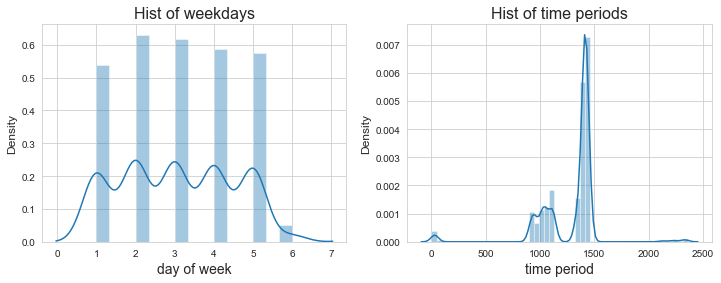

In [179]:
## plotting distributions of weekdays and time periods
# weekdays 
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.set_style("whitegrid")
sns.distplot(weekdays_0)
plt.ylabel('Density', fontsize=12)
plt.xlabel('day of week', fontsize=14)
plt.title('Hist of weekdays', fontsize=16)

# time periods
plt.subplot(122)
sns.set_style("whitegrid")
sns.distplot(time_periods_0)
plt.ylabel('Density', fontsize=12)
plt.xlabel('time period', fontsize=14)
plt.title('Hist of time periods', fontsize=16)

From the distribution, we can know see very clear that non-trades concentrate on day of weeks and also some on saturday. As for time periods non-trades, they mainly concentrate on morning and afternoon trading periods. This is consistent with the rule of futures trading.

##### checking the time period 

In [169]:
## figure out the morning, afternoon and night period.
unique_time = pd.DataFrame(cu_data.date.map(lambda x: x.time()).unique())
unique_time.columns =["time"]

,time
0,09:01:00
1,09:02:00
2,09:03:00
3,09:04:00
4,09:05:00


From the result, we can find out that the morning trade starts from 09:00 to 11:30, the afternoon trade starts from 13:30 to 15:00,, the night trade starts from 21:00 to 01:00. There is a 15-minute break for morning trade from 10:15 to 10:30.

In [60]:
## the num of morning trading
cu_data_new = cu_data.copy()
cu_data_new['date'] = cu_data_new.date.map(lambda x: int(x.time().strftime('%H%M')))
morning_nums = len(cu_data_new[cu_data_new['date'].map(lambda x: x in range(900,1131))])
print("there are %d morning trades in total, %d morning trades per minute on average" \
      %(morning_nums,(morning_nums/135)))


## the num of afternoon trading
afternoon_nums = len(cu_data_new[cu_data_new['date'].map(lambda x: x in range(1330,1501))])
print("there are %d afternoon trades in total, %d afternoon trades per minute on average"\
      % (afternoon_nums,(afternoon_nums/90)))

## the num of night trading
night_nums = len(cu_data_new[cu_data_new['date'].map(lambda x: x in range(2100,2400) or x in range(0,101))])
print("there are %d night trades in total, %d night trades per minute on average"\
      % (night_nums, (night_nums/240)))

there are 475470 morning trades in total, 3522 morning trades per minute on average
there are 316980 afternoon trades in total, 3522 afternoon trades per minute on average
there are 313680 night trades in total, 1307 night trades per minute on average


In [10]:
## creating dataframe for both total and average
df_total = pd.DataFrame([475470,316980,313680],\
                         index = ['morning trades','afternoon trades','night trades'], columns=['total trades'])
df_total
df_average = pd.DataFrame([3522,3522,1307],index = ['morning trades','afternoon trades','night trades'],\
                          columns=['average trades(minutes)'])
df_average

,average trades(minutes)
morning trades,3522
afternoon trades,3522
night trades,1307


Text(0.5, 1.0, 'average trades per minutes')

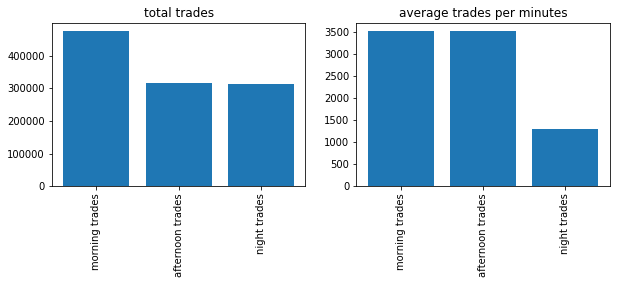

In [37]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].bar(df_total.index, df_total.ix[:,0])
ax[0].set_xticklabels(df_total.index, rotation =90)
ax[0].set_title('total trades')

ax[1].bar(df_average.index, df_average.ix[:,0])
ax[1].set_xticklabels(df_average.index, rotation =90)
ax[1].set_title('average trades per minutes')

From the two graph, we can see that the total and average trades in morning is the highest. The average trade of night is kind of low, this is because night trade has longer trading period.

### checking relationship between prices and different time periods

##### checking the mean prices

In [61]:
## group by different date
grouped = cu_data_new.groupby(['date'])

## morning grouped data
morn_group = grouped.mean()[grouped.mean().index.map(lambda x: x in range(900,1131))]

## afternoon grouped data
noon_group = grouped.mean()[grouped.mean().index.map(lambda x: x in range(1330,1501))]

## night grouped data
night_group = grouped.mean()[grouped.mean().index.map(lambda x: x in range(2100,2400) or x in range(0,101))]
night_group.head()

,open,close,high,low,volume,money,open_interest
date,,,,,,,
0,45728.140780,45727.850038,45738.163734,45717.605203,360.174445,7.954027e+07,242227.935731
1,45727.605203,45727.773527,45739.984698,45716.151492,417.418516,9.271474e+07,242218.821729
2,45727.536343,45728.400918,45737.459832,45718.607498,304.543229,6.805048e+07,242211.306809
3,45728.316756,45728.798776,45737.589901,45719.387911,292.220352,6.501092e+07,242199.276205
4,45728.592196,45728.309105,45737.674063,45719.280796,296.157613,6.590805e+07,242188.950268


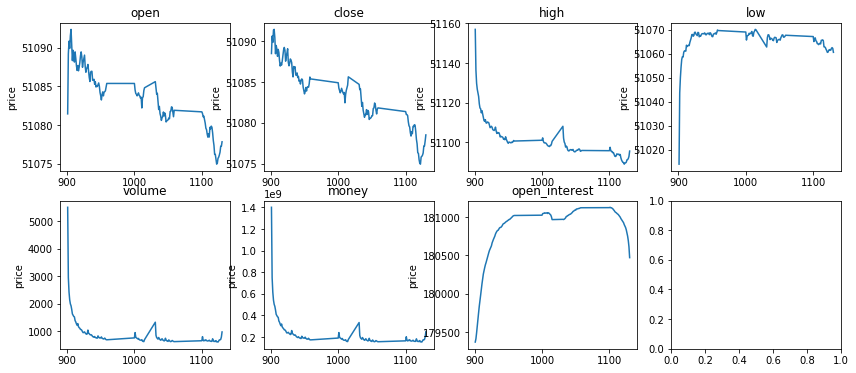

In [90]:
## morning visualization
fig, axes = plt.subplots(2,4, figsize=(14,6), squeeze = False)
for i, columns in enumerate(morn_group.columns):
    x = morn_group.index
    y = morn_group[columns]
    ax = axes[i//4, i%4]
    ax.plot(x,y)
    ax.set_title(columns)
    ax.set_ylabel("price")

For the morning period, the mean open, and close prices fluctuate decreasingly as time, while the mean low price increase dramatically at first several minutes, and then stays kind of stable in the following time. As for mean high price, it is contrary to mean low price, which decreases dramatically at first several minutes, and then decreases gradually. And the trend of open_interest is similar to that of mean low price.

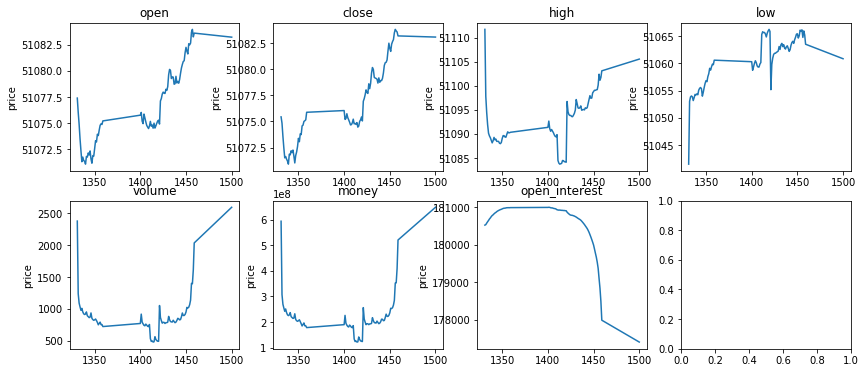

In [91]:
## afternoon visualization
fig, axes = plt.subplots(2,4, figsize=(14,6), squeeze = False)
for i, columns in enumerate(noon_group.columns):
    x = noon_group.index
    y = noon_group[columns]
    ax = axes[i//4, i%4]
    ax.plot(x,y)
    ax.set_title(columns)
    ax.set_ylabel("price")

For the afternoon period, we can see that the mean open and close prices have simiar trends, while the mean high and low prices have kind of contrary trends. 

In [146]:
## adjusitng the date for night data.
# night_group['date'] = night_group.index
# night_group['date'][0:60] = night_group['date'][0:60] + 2400
# night_group['date'][100] = 2460

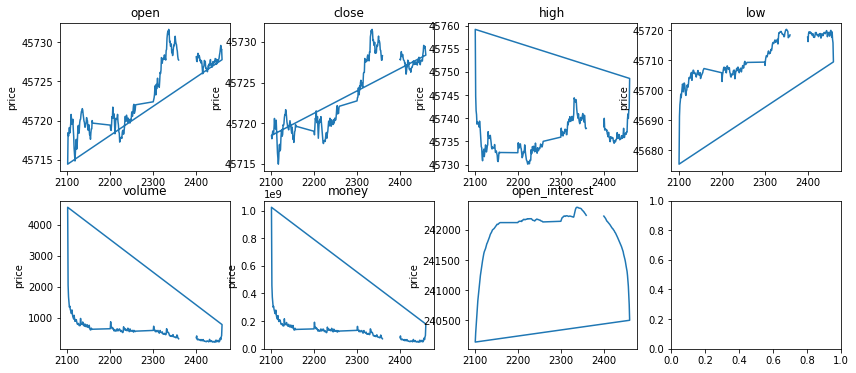

In [150]:
## night visualization
fig, axes = plt.subplots(2,4, figsize=(14,6), squeeze = False)
for i, columns in enumerate(night_group.columns[0:7]):
    x = night_group['date']
    y = night_group[columns]
    ax = axes[i//4, i%4]
    ax.plot(x,y)
    ax.set_title(columns)
    ax.set_ylabel("price")

Fot night period, the conculsion is similar to the conclusion above.

In the end, we find that, we can see that the mean open and close prices have simiar trends, while the mean high and low prices have kind of contrary trends. Those two can be our poential features. One more thing we notice is that, in the morning and night period, the trends and open interests are similar to that of mean low price, while in the afternoon period, those two are kind of contrary. There might be something behind it.

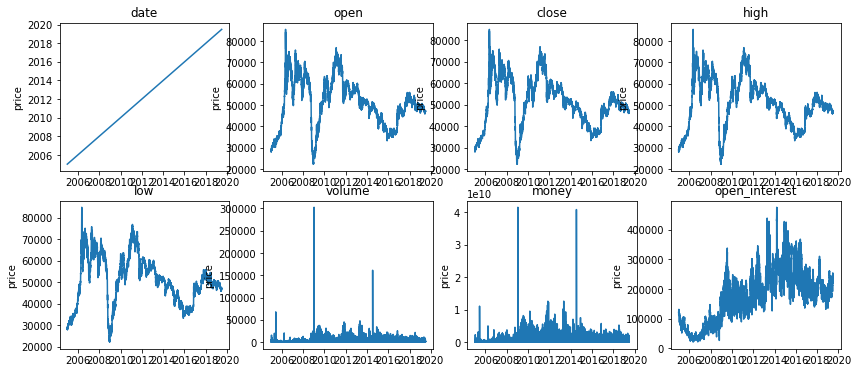

In [213]:
## Look at all varaible trends
fig, axes = plt.subplots(2,4, figsize=(14,6), squeeze = False)
for i, columns in enumerate(cu_data.columns):
    x = cu_data.date
    y = cu_data[columns]
    ax = axes[i//4, i%4]
    ax.plot(x,y)
    ax.set_title(columns)
    ax.set_ylabel('price')

From the graph we can see that there are something interesting. For example, in 2008, all variables have low prices, with relatively high volume, money and open_interest. This is probrably due to financial crisis. Another special year is 2016, in which those variables have similar to that of 2008. This can be a research direction.

In [78]:
# unique_dates
# apply(datetime.date.weekday(), unique_dates)
# pd.DataFrame(unique_dates)(lambda x: datetime.date.weekday(x))
pd.DataFrame(unique_dates).ix[1:3,0]

1    2005-01-05
2    2005-01-06
3    2005-01-07
Name: 0, dtype: object

### The 5-minute close price return exploration

In [18]:
## get 5 minutes frequency mean close price
cu_close  = cu_data[['date','close']].set_index('date')
minute5_close = cu_close.resample('min',how = 'mean')

## get the 5 minutes frequency mean close price return
close_ret5m = minute5_close.ta.percent_return()
close_ret5m.describe()

count    1.523136e+06
mean     5.586453e-07
std      6.965042e-04
min     -6.108392e-02
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.634897e-02
Name: PCTRET_1, dtype: float64

We can see that the 25%, 50%, 75% are 0, which means the mean of close return of 5 minutes might converge into 0 in long run.

In [34]:
close_ret5m = pd.DataFrame(close_ret5m).rename(columns={'PCTRET_1':'close_return'})
close_ret5m.head()

,close_return
date,
2005-01-04 09:00:00,NaN
2005-01-04 09:05:00,-0.002734
2005-01-04 09:10:00,0.000828
2005-01-04 09:15:00,0.001654
2005-01-04 09:20:00,0.001514


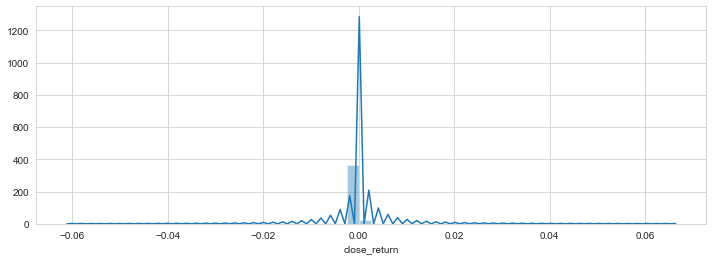

In [58]:
## plot distribution of 5 minutes close price return
fig,axes = plt.subplots(figsize=(12,4), squeeze=False)
sns.distplot(close_ret5m['close_return'])

In [91]:
close_ret5m_new = close_ret5m.set_index(close_ret5m.index.map(lambda x: int(x.time().strftime('%H%M'))))
close_ret5m_new.head()

,close_return
date,
900,NaN
905,-0.002734
910,0.000828
915,0.001654
920,0.001514


In [122]:
## get morning period 5 minutes close mean return 
morn_ret5m = close_ret5m_new[close_ret5m_new.index.map(lambda x: x in range(900,1131))].dropna()
morn_ret5m_grouped  = morn_ret5m.groupby(morn_ret5m.index).mean()

## get afternoon period 5 minutes close mean return 
noon_ret5m = close_ret5m_new[close_ret5m_new.index.map(lambda x: x in range(1330,1501))].dropna()
noon_ret5m_grouped  = noon_ret5m.groupby(noon_ret5m.index).mean()

## get night period 5 minutes close mean return 
night_ret5m = close_ret5m_new[close_ret5m_new.index.map(lambda x: x in range(2100,2400) or x in range(0,101))].dropna()
night_ret5m_grouped = night_ret5m.groupby(night_ret5m.index).mean()

In [123]:
# # adjusitng the date for night data.
# night_ret5m_grouped['date1'] = night_ret5m_grouped.index
# night_ret5m_grouped['date1'][0:12] = night_ret5m_grouped['date1'][0:12] + 2400
# night_ret5m_grouped['date1'][100] = 2460
# night_ret5m_grouped.sort_values(by='date1')
night_ret5m_grouped.head()

,close_return,date1
date,,
0,-1.868993e-07,2400
5,-7.362864e-07,2405
10,-5.405778e-06,2410
15,5.096956e-08,2415
20,-1.129248e-06,2420


Text(0.5, 1.0, '5 mins night period')

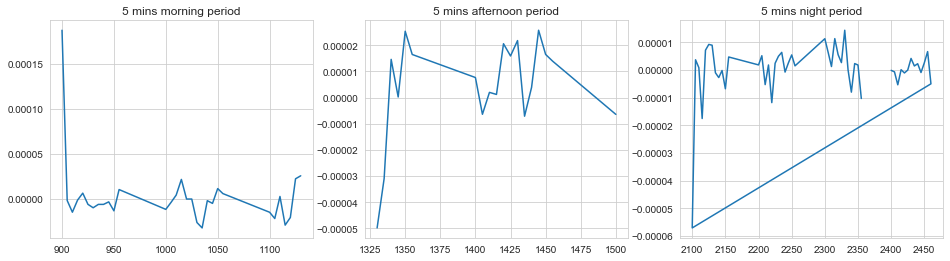

In [191]:
## compare 3 periods 
fig, axes = plt.subplots(1,3, figsize=(16,4), squeeze = False)
axes[0,0].plot(morn_ret5m_grouped)
axes[0,0].set_title('5 mins morning period')

axes[0,1].plot(noon_ret5m_grouped)
axes[0,1].set_title('5 mins afternoon period')

axes[0,2].plot(night_ret5m_grouped['date1'],night_ret5m_grouped['close_return'])
axes[0,2].set_title('5 mins night period')

From the graph, we can see that the morning time period starts from a high value, ends at a low value, while for both afternoon and night periods, it's the opposite way. Also, we can find especailly in afternoon and night period graphs that a raise usually followed by a raise; a decrease usually follwed by a decrease. We need to see that if there is any pattern in other period levels(10mins, monthly). 

### The 10-minute close price return exploration

In [183]:
## get 10 minutes frequency mean close price
cu_close  = cu_data[['date','close']].set_index('date')
minute10_close = cu_close.resample('10min',how = 'mean')

## get the 10 minutes frequency mean close price return
close_ret10m = minute10_close.ta.percent_return()
close_ret10m.describe()

count    761568.000000
mean          0.000001
std           0.000976
min          -0.060161
25%           0.000000
50%           0.000000
75%           0.000000
max           0.065677
Name: PCTRET_1, dtype: float64

In [184]:
close_ret10m = pd.DataFrame(close_ret10m).rename(columns={'PCTRET_1':'close_return'})
close_ret10m.head()

,close_return
date,
2005-01-04 09:00:00,NaN
2005-01-04 09:10:00,0.000436
2005-01-04 09:20:00,0.002100
2005-01-04 09:30:00,-0.001340
2005-01-04 09:40:00,0.000860


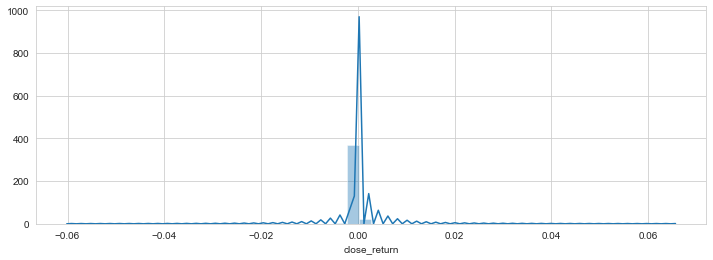

In [185]:
## plot distribution of 5 minutes close price return
fig,axes = plt.subplots(figsize=(12,4), squeeze=False)
sns.distplot(close_ret10m['close_return'])

In [186]:
close_ret10m_new = close_ret10m.set_index(close_ret10m.index.map(lambda x: int(x.time().strftime('%H%M'))))
close_ret10m_new.head()

,close_return
date,
900,NaN
910,0.000436
920,0.002100
930,-0.001340
940,0.000860


In [187]:
## get morning period 10 minutes close mean return 
morn_ret10m = close_ret10m_new[close_ret10m_new.index.map(lambda x: x in range(900,1131))].dropna()
morn_ret10m_grouped  = morn_ret10m.groupby(morn_ret10m.index).mean()

## get afternoon period 10 minutes close mean return 
noon_ret10m = close_ret10m_new[close_ret10m_new.index.map(lambda x: x in range(1330,1501))].dropna()
noon_ret10m_grouped  = noon_ret10m.groupby(noon_ret10m.index).mean()

## get night period 10 minutes close mean return 
night_ret10m = close_ret10m_new[close_ret10m_new.index.map(lambda x: x in range(2100,2400) or x in range(0,101))].dropna()
night_ret10m_grouped = night_ret10m.groupby(night_ret10m.index).mean()

In [189]:
# # adjusitng the date for night data.
night_ret10m_grouped['date1'] = night_ret10m_grouped.index
night_ret10m_grouped['date1'][0:6] = night_ret10m_grouped['date1'][0:6] + 2400
night_ret10m_grouped['date1'][100] = 2460
night_ret10m_grouped.sort_values(by='date1')
night_ret10m_grouped.head()

,close_return,date1
date,,
0,-0.000006,2400
10,-0.000006,2410
20,-0.000001,2420
30,0.000005,2430
40,0.000002,2440


Text(0.5, 1.0, '10 mins night period')

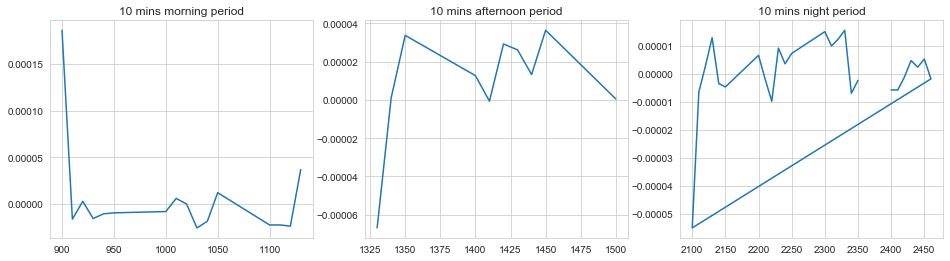

In [190]:
## compare 3 periods 
fig, axes = plt.subplots(1,3, figsize=(16,4), squeeze = False)
axes[0,0].plot(morn_ret10m_grouped)
axes[0,0].set_title('10 mins morning period')

axes[0,1].plot(noon_ret10m_grouped)
axes[0,1].set_title('10 mins afternoon period')

axes[0,2].plot(night_ret10m_grouped['date1'],night_ret10m_grouped['close_return'])
axes[0,2].set_title('10 mins night period')

In [180]:
night_ret10m_grouped

,close_return
date,
0,-0.000014
30,0.000005
100,0.000003
2100,-0.000058
2130,0.000009
2200,-0.000002
2230,0.000007
2300,0.000032
2330,0.000022


we can see that the distribution is kind of normal

In [85]:
## period analysis of 5 minutes close price return
# morning period 
morn_new = morn_group.set_index(morn_group.index.\
                                      map(lambda x: datetime.datetime.strptime(str(x),'%H%M').time()))
morn_5m = morn_new.resample(rule='5m'
morn_return = morn_group_new.ta.percent_return()
morn_return.head()

date
09:01:00         NaN
09:02:00    0.000042
09:03:00   -0.000015
09:04:00    0.000030
09:05:00    0.000001
Name: PCTRET_1, dtype: float64

In [86]:
cu_data_new.head()

,date,open,close,high,low,volume,money,open_interest
0,901,29110,29080,29170,29080,3158,459908300,121604
1,902,29080,29100,29100,29030,1970,286417600,121806
2,903,29110,29060,29110,29060,1418,206240600,122000
3,904,29060,29070,29080,29050,942,136908100,122024
4,905,29080,29070,29090,29060,1134,164892800,122198


In [68]:
close_ret5m.head()

,close_return
date,
2005-01-04 09:00:00,NaN
2005-01-04 09:05:00,-0.002734
2005-01-04 09:10:00,0.000828
2005-01-04 09:15:00,0.001654
2005-01-04 09:20:00,0.001514


In [82]:
morn_group.head()

,open,close,high,low,volume,money,open_interest
date,,,,,,,
901,51081.456559,51088.506530,51157.010221,51014.074390,5512.651334,1.401514e+09,179371.344691
902,51089.196479,51090.653038,51136.439523,51043.773424,2958.580920,7.487161e+08,179413.802385
903,51090.846110,51089.872232,51129.787053,51050.122090,2431.520727,6.146143e+08,179492.169790
904,51089.911982,51091.396934,51126.771721,51054.474730,2148.834185,5.410992e+08,179583.633163
905,51091.533220,51091.470755,51125.031232,51057.694492,1998.939239,5.027820e+08,179671.163543


In [84]:
morn_group_new.head()

,open,close,high,low,volume,money,open_interest
date,,,,,,,
09:01:00,51081.456559,51088.506530,51157.010221,51014.074390,5512.651334,1.401514e+09,179371.344691
09:02:00,51089.196479,51090.653038,51136.439523,51043.773424,2958.580920,7.487161e+08,179413.802385
09:03:00,51090.846110,51089.872232,51129.787053,51050.122090,2431.520727,6.146143e+08,179492.169790
09:04:00,51089.911982,51091.396934,51126.771721,51054.474730,2148.834185,5.410992e+08,179583.633163
09:05:00,51091.533220,51091.470755,51125.031232,51057.694492,1998.939239,5.027820e+08,179671.163543


In [33]:
# cu_data[cu_data['volume']==0].date

## Analysis
1. time series AR(1), AR(2)
2. holiday analysis, after and before holiday, price, amount. (holiday lists)(how about friday and monday?)
3. compare different time/trading period, morning, afternoon, as well as friday nights, any significant difference?
4. index analysis, MACD,DMA,CR?? there are so many indexs, which one should I choose?
5. period analysis 1 min, 2 mins, 5 mins, 10 mins? which period has the highest profits interval?

### Time Series Analysis

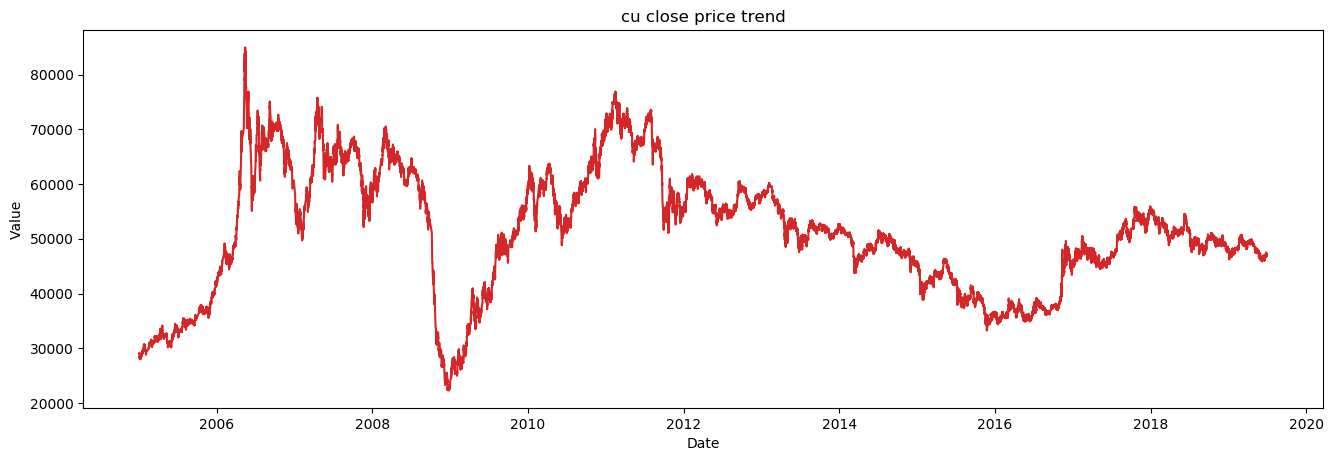

In [5]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(cu_data[['date','close']], x=cu_data[['date']], y=cu_data[['close']],\
        title='cu close price trend') 

From the graph, we can know that there seems to be stochastic trend of cu close price, thus, we need to check and avoid this problem.

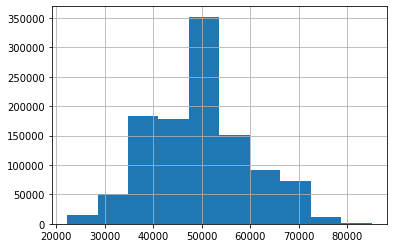

In [4]:
## check stationary & non-stationary
cu_data['close'].hist()
plt.show()

Running the example plots a histogram of values from the time series. We clearly see the bell curve-like shape of the Gaussian distribution, with a longer right tail.

In [5]:
## ADF test for close price
from statsmodels.tsa.stattools import adfuller
X = cu_data['close'][1:10000]
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.844799
p-value: 0.805607
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In summary, we can know that p-value is 0.805607, thus, we failed to reject the null hypothesis and reach the conclusion that the close price has a unit root, which means it's non-stationary, thus we need to get the first diff of the close price.

In [3]:
## get the price return(first diff) of close price
close_return = cu_data.ta.percent_return()
close_return.head()

0         NaN
1    0.000688
2   -0.001375
3    0.000344
4    0.000000
Name: PCTRET_1, dtype: float64

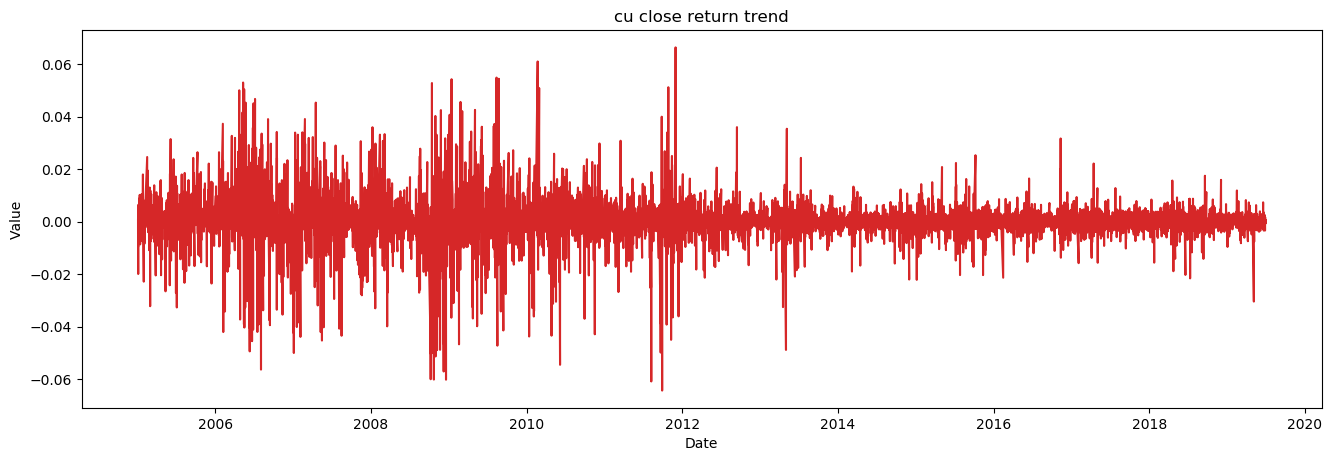

In [6]:
## draw plot of cu close return
df = close_return.copy()
df = pd.DataFrame(df).set_index(cu_data.date)
plot_df(df, x=df.index, y=df.ix[:,0:],\
        title='cu close return trend') 

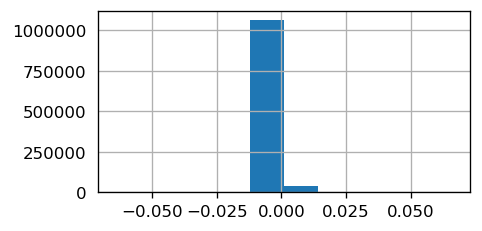

In [44]:
## check stationary & non-stationary
close_return.hist(figsize=(4,2))
plt.show()

In [103]:
## ADF test for close return
X2 = close_return[1:1000]
result_return = adfuller(X2)
print('ADF Statistic: %f' % result_return[0])
print('p-value: %f' % result_return[1])
print('Critical Values:')
for key, value in result_return[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -27.703475
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


In summary, we can know that p-value is 0, thus, we reject the null hypothesis and reach the conclusion that the close return doesn't have a unit root, which means it's stationary. And we can use this data to do forecasting.

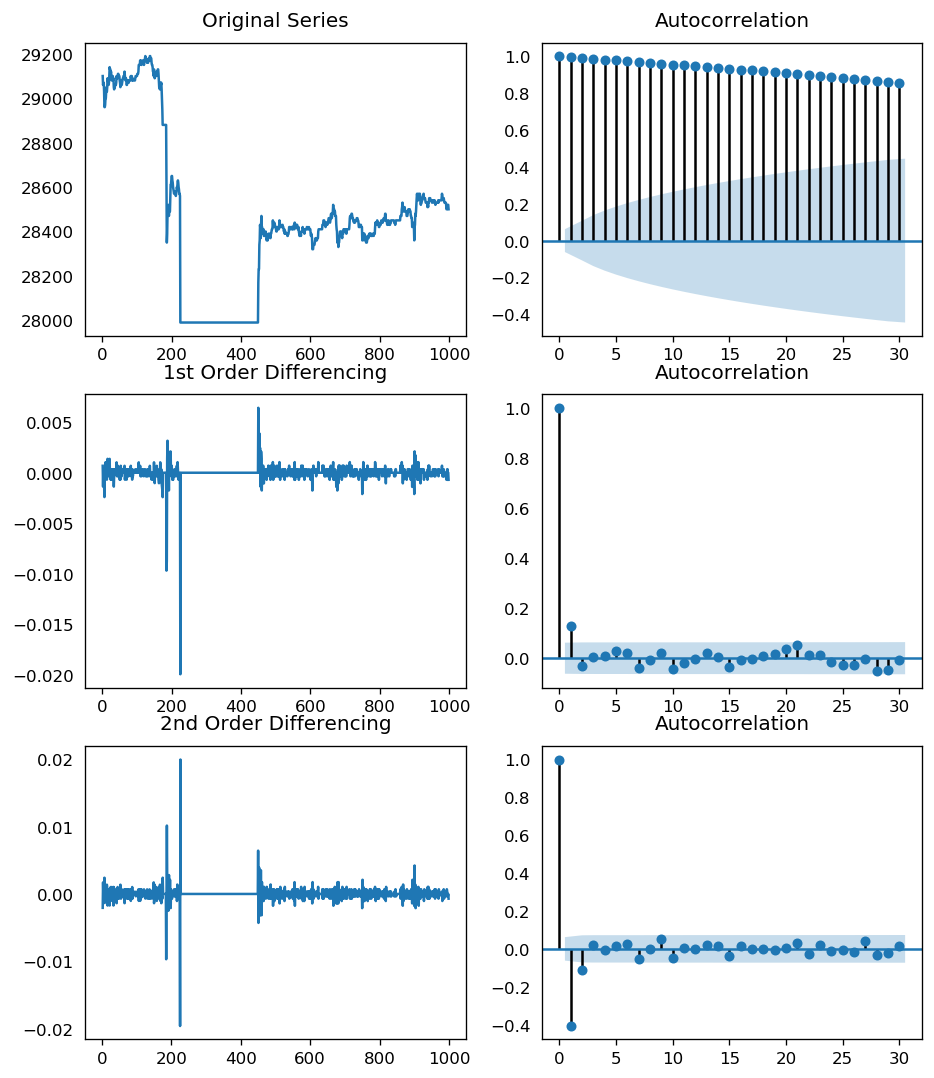

In [46]:
## determine the orders of differencing
plt.rcParams.update({'figure.figsize':(9,11), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(cu_data.close[1:1000]); axes[0, 0].set_title('Original Series')
plot_acf(cu_data.close[1:1000], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(close_return[1:1000]); axes[1, 0].set_title('1st Order Differencing')
plot_acf(close_return[1:1000].dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(close_return[1:1000].diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(close_return[1:1000].diff().dropna(), ax=axes[2, 1])

plt.show()

In summary we decide to choose the first order differencing. d =1.

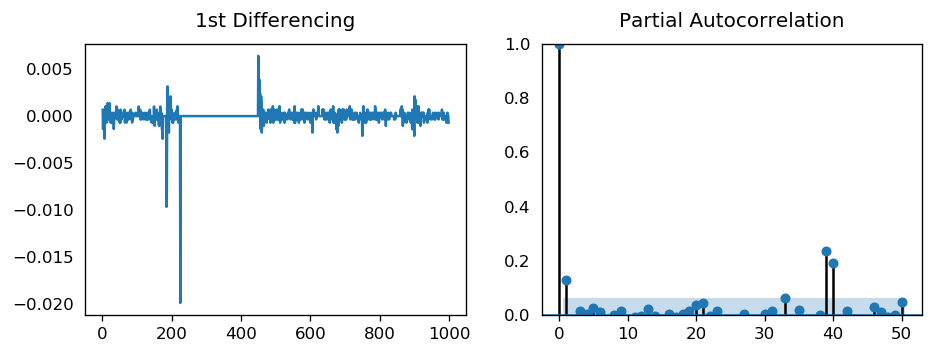

In [50]:
## Find AR term (p)
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(close_return[1:1000]); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1))
plot_pacf(close_return[1:1000].tolist(), lags=50, ax=axes[1])

plt.show()

p = 1 might be the best, it's above the significance line.

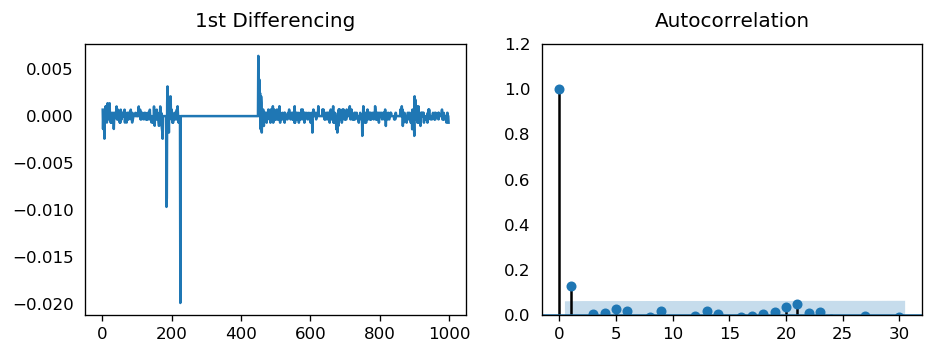

In [52]:
## Find MA term (1)
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(close_return[1:1000]); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(close_return[1:1000].dropna(), ax=axes[1])

plt.show()

q = 1 might be the best, it's above the significance line.

Finally, our ARIMA model is with order q=p=d=1.

In [106]:

# 1,1,1 ARIMA Model
model = ARIMA(close_return[1:1000], order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:               PCTRET_1   No. Observations:                  999
Model:                     ARMA(1, 1)   Log Likelihood                5579.273
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 26 Dec 2019   AIC                         -11150.546
Time:                        19:48:12   BIC                         -11130.919
Sample:                             0   HQIC                        -11143.086
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.969e-05    3.2e-05     -0.616      0.538   -8.23e-05     4.3e-05
ar.L1.PCTRET_1    -0.2189      0.202     -1.083      0.279      -0.615       0.177
ma.L1.PCTRET_1     0.3558      0.193

From the table, we can see that, the result is kind of insignificant. We might concern that this model is a little bit under differencinhg, thus, we decide to try ARIMA(1,0,2) model.

In [138]:
# 1,0,2 ARIMA Model
model2 = ARIMA(close_return[1:1000], order=(1,0,2))
model2_fit = model2.fit(disp=0)
print(model2_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.PCTRET_1   No. Observations:                  998
Model:                 ARIMA(3, 1, 5)   Log Likelihood                5550.528
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 26 Dec 2019   AIC                         -11081.057
Time:                        20:00:48   BIC                         -11031.999
Sample:                             1   HQIC                        -11062.410
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2.931e-08   2.69e-06     -0.011      0.991   -5.31e-06    5.25e-06
ar.L1.D.PCTRET_1    -0.9463      0.143     -6.620      0.000      -1.227      -0.666
ar.L2.D.PCTRET_1    -0.9847 

From the result, we can see all coefficient are significant now!

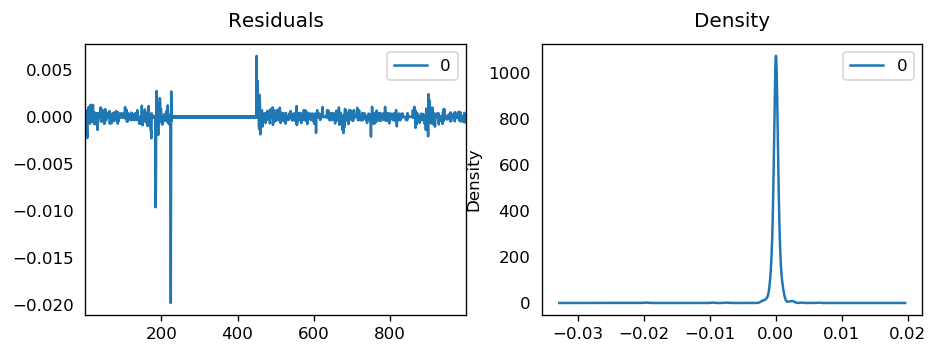

In [74]:
# Plot residual errors
residuals = pd.DataFrame(model2_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance.

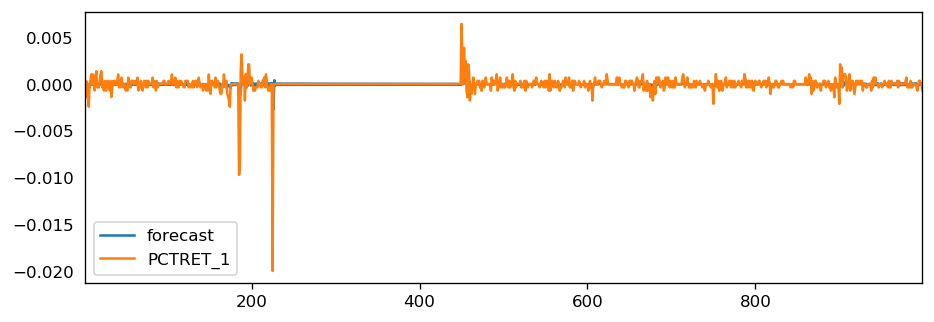

In [75]:
# Actual vs Fitted (in sample)
model2_fit.plot_predict(dynamic=False)
plt.show()

In [273]:
## Out-of-Time cross-validation
# Create Training and Test
train = close_return[1:501]
test = close_return[501:701]
train = train.tolist()
test = test.tolist()

In [271]:
len(test)

500

In [274]:
fc = []
conf =[]
for t in range(len(test)):
    train = train[len(train)-500:]
    model3 = ARIMA(train, order=(1, 0, 1))
    model3_fit = model3.fit(disp=-1)
    fc.append(model3_fit.forecast()[0][0]) 
    conf.append(model3_fit.forecast()[2][0])
    train.append(test[t])

#### 

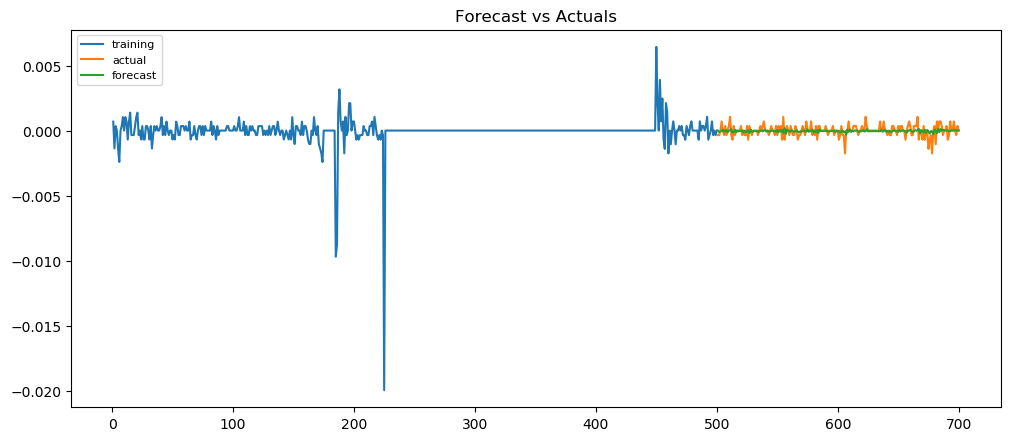

In [275]:
train = close_return[1:501]
test = close_return[501:701]
conf = pd.DataFrame(conf)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf.ix[:, 0], index=test.index)
upper_series = pd.Series(conf.ix[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [255]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [276]:
forecast_accuracy(pd.Series(fc), test)

{'mape': nan,
 'me': nan,
 'mae': nan,
 'mpe': nan,
 'rmse': nan,
 'acf1': -0.19381528897543013,
 'corr': -0.04636988424551419,
 'minmax': inf}

In [ ]:
model = ARIMA(history, order=order)
model_fit = model.fit(disp=-1)
predictions_f_ms = model_fit.forecast(steps=len(test))[0]

In [87]:

#     yhat_p = model_fit.predict(start=len(history), end=len(history))[0]
#     predictions_f.append(fc)
#     predictions_p.append(yhat_p)
    

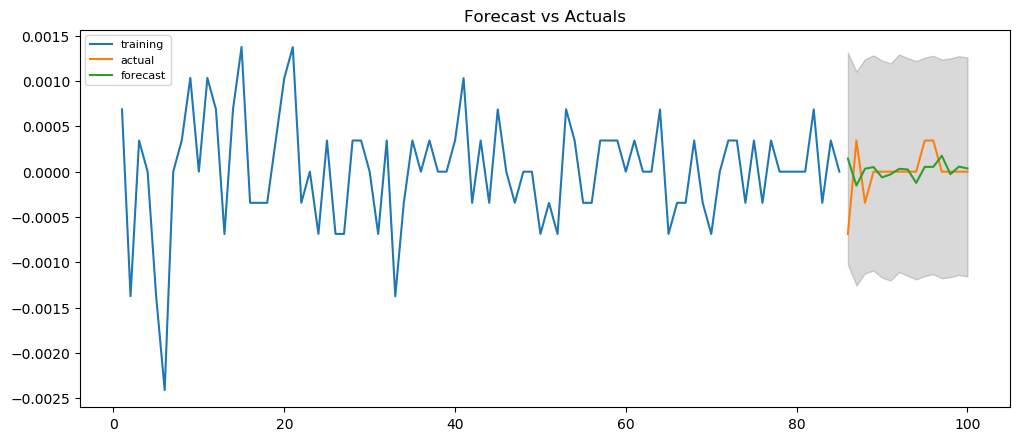

In [100]:
fc_series = pd.Series(fc, index=test.index)
# lower_series = pd.Series(conf[:, 0], index=test.index)
# upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [115]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
import pmdarima as pm
model3 = ARIMA(train, order=(3, 1, 4))  
fitted = model3.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(steps = 5, alpha=0.05)  # 95% conf
# fc = fitted.predict()
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

ValueError: Length of passed values is 5, index implies 15

In [114]:
forecast_accuracy(pd.Series(fc), test)

{'mape': nan,
 'me': nan,
 'mae': nan,
 'mpe': nan,
 'rmse': nan,
 'acf1': -0.3915590287777796,
 'corr': -0.3976967405197935,
 'minmax': inf}

In [149]:
fc

array([ 1.44133772e-04, -7.55041979e-05,  6.01271694e-05,  9.60751279e-05,
        2.82400814e-05, -2.76927382e-06,  9.31088862e-05,  5.19556221e-05,
        1.58252793e-05,  5.44164080e-05,  7.37179226e-05,  3.05448783e-05,
        4.27918011e-05,  6.79048284e-05,  5.09404861e-05])

### Forecasting Time Series Data using Autoregression

In [38]:
#create train/test datasets
train_data = close_return[1:int(len(close_return)/2)]
test_data = close_return[int(len(close_return)/2)-1:]

In [39]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import r2_score
 
#train the autoregression model
model = AR(train_data)
model_fitted = model.fit()
 
print('The lag value chose is: %s' % model_fitted.k_ar)

The lag value chose is: 103


#### test seasonality

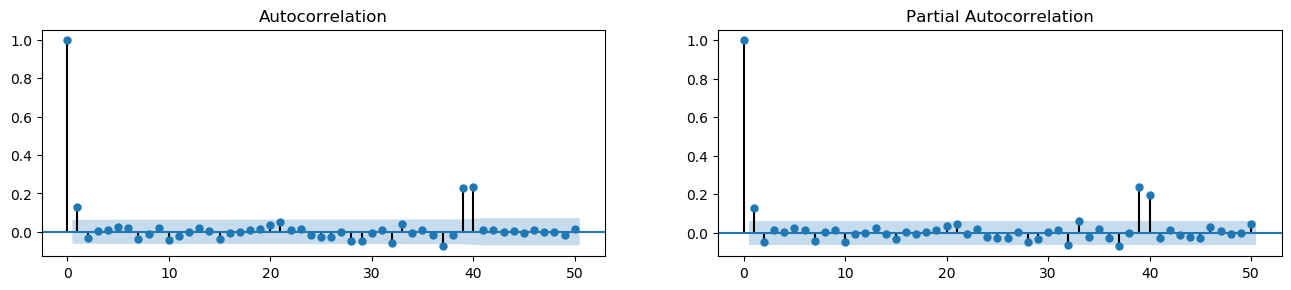

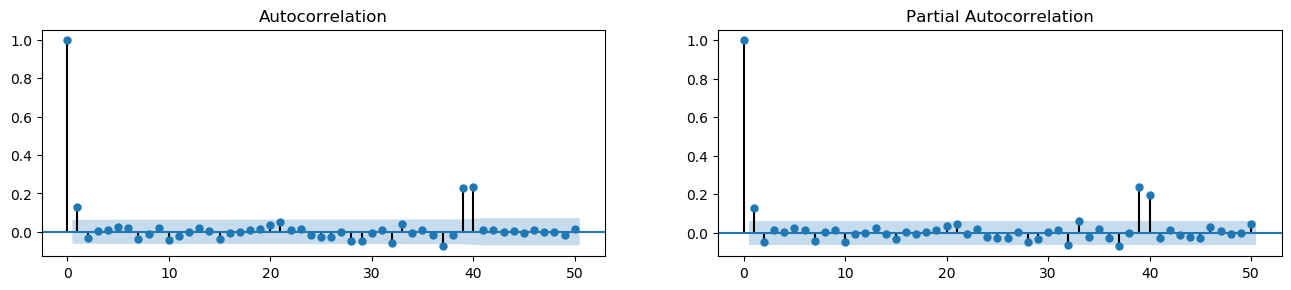

In [19]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot of price return
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(close_return[1:1000].tolist(), lags=50, ax=axes[0])
plot_pacf(close_return[1:1000].tolist(), lags=50, ax=axes[1])

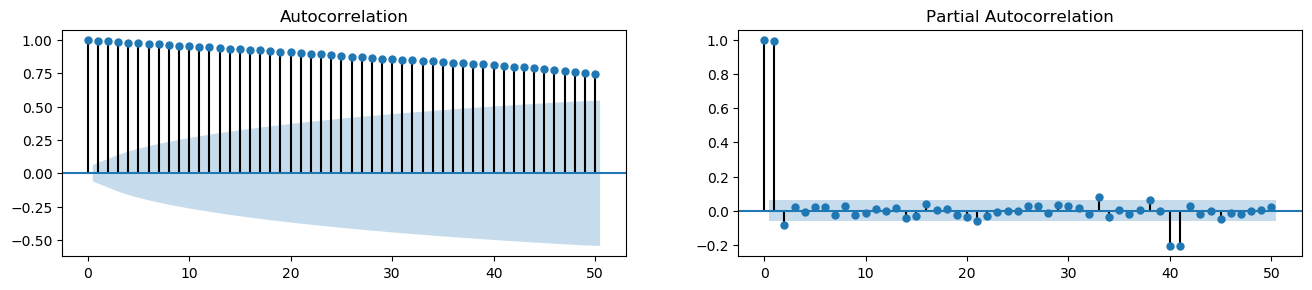

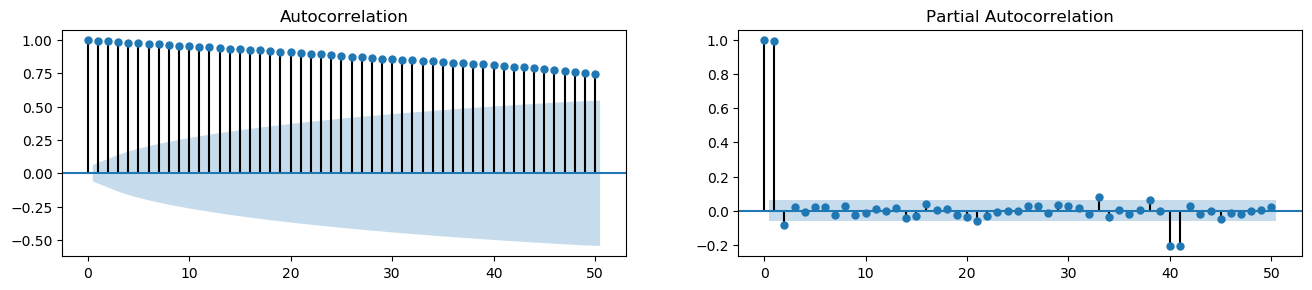

In [21]:
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(cu_data['close'][1:1000].tolist(), lags=50, ax=axes[0])
plot_pacf(cu_data['close'][1:1000].tolist(), lags=50, ax=axes[1])

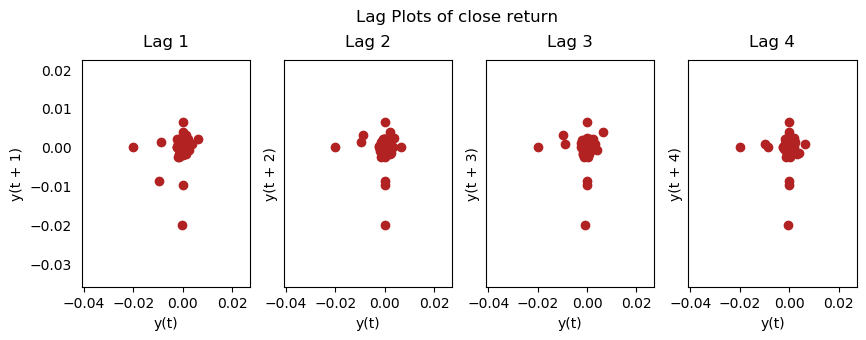

In [22]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(close_return[1:1000], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of close return', y=1.05)    
plt.show()

### ARIMA Model

In [16]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# from dateutil.parser import parse
# # Multiplicative Decomposition 
# result_mul = seasonal_decompose(cu_data['close'], model='multiplicative',extrapolate_trend='None')

# # Additive Decomposition
# result_add = seasonal_decompose(cu_data['close'], model='additive', extrapolate_trend='None')

# # Plot
# plt.rcParams.update({'figure.figsize': (10,10)})
# result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
# result_add.plot().suptitle('Additive Decompose', fontsize=22)
# plt.show()

In [3]:
cu_data.head()

,date,open,close,high,low,volume,money,open_interest
0,2005-01-04 09:01:00,29110,29080,29170,29080,3158,459908300,121604
1,2005-01-04 09:02:00,29080,29100,29100,29030,1970,286417600,121806
2,2005-01-04 09:03:00,29110,29060,29110,29060,1418,206240600,122000
3,2005-01-04 09:04:00,29060,29070,29080,29050,942,136908100,122024
4,2005-01-04 09:05:00,29080,29070,29090,29060,1134,164892800,122198


##### AR(1) & AR(2)

In [179]:
## shift to get first lag data
cu_data.shift(1).head()

,date,open,close,high,low,volume,money,open_interest
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-04 09:01:00,29110.0,29080.0,29170.0,29080.0,3158.0,459908300.0,121604.0
2,2005-01-04 09:02:00,29080.0,29100.0,29100.0,29030.0,1970.0,286417600.0,121806.0
3,2005-01-04 09:03:00,29110.0,29060.0,29110.0,29060.0,1418.0,206240600.0,122000.0
4,2005-01-04 09:04:00,29060.0,29070.0,29080.0,29050.0,942.0,136908100.0,122024.0


Text(0.5, 1.0, 'low')

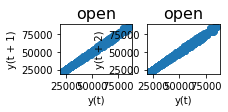

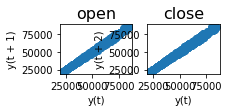

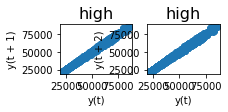

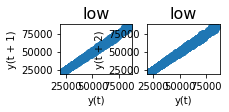

In [232]:
## plot lag1 and lag2 for open
plt.figure(figsize=(6,2))
plt.subplot(2,4,1)
lag_plot(cu_data['open'])
plt.title('open', fontsize=16)
plt.subplot(2,4,2)
lag_plot(cu_data['open'], lag=2)
plt.title('open', fontsize=16)

## plot lag1 and lag2 for close
plt.figure(figsize=(6,2))
plt.subplot(2,4,3)
lag_plot(cu_data['close'])
plt.title('open', fontsize=16)
plt.subplot(2,4,4)
lag_plot(cu_data['close'], lag=2)
plt.title('close', fontsize=16)

## plot lag1 and lag2 for high
plt.figure(figsize=(6,2))
plt.subplot(2,4,5)
lag_plot(cu_data['high'])
plt.title('high', fontsize=16)
plt.subplot(2,4,6)
lag_plot(cu_data['high'], lag=2)
plt.title('high', fontsize=16)

## plot lag1 and lag2 for close
plt.figure(figsize=(6,2))
plt.subplot(2,4,7)
lag_plot(cu_data['low'])
plt.title('low', fontsize=16)
plt.subplot(2,4,8)
lag_plot(cu_data['low'], lag=2)
plt.title('low', fontsize=16)

From the graphs, we can easily get that all the prices are autoregressive with its first lag and second lag.

### Holiday analysis

### Period Exploration

In [229]:
time_intvals = [(i+1)*5 for i in range(60)]
max_min_list = []
for intval in time_intvals:
    df = cu_data.close\
                .rolling(intval)\
                .agg({'max': np.max,
                      'min': np.min})\
                .dropna()\
                .astype('int32')
    max_min = np.mean(df['max']-df['min'])
    max_min_list.append(max_min)

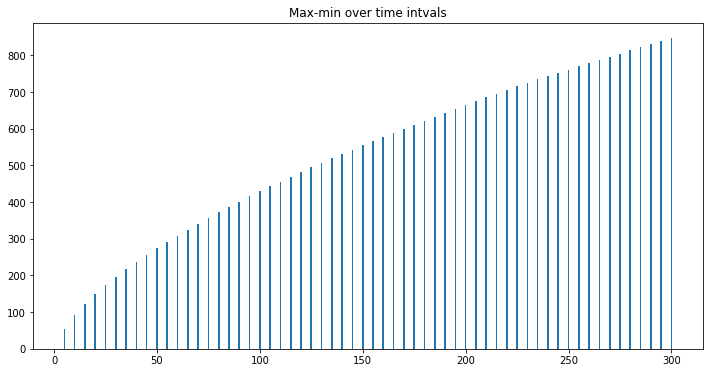

In [230]:
plt.figure(figsize=(12,6))
plt.bar(time_intvals, max_min_list)
plt.title('Max-min over time intvals')
plt.show()

In [231]:
spread = 20
unit = 5
cost = 15
print('Possible profits over time interval: ', (np.array(max_min_list)-spread)*unit - cost)

Possible profits over time interval:  [ 150.6708187   344.31417087  497.59167212  630.62833206  750.88681374
  862.28439808  966.95310353 1066.25913691 1161.15777616 1252.56408437
 1340.89801243 1426.29124622 1508.98062141 1589.32955325 1667.618692
 1743.9725971  1818.4878477  1891.2093087  1961.82159532 2030.8317624
 2098.51491737 2164.97311986 2230.25156056 2294.50478793 2357.75534672
 2420.0247875  2481.36865775 2541.66443036 2601.02154096 2659.51113536
 2717.16602349 2774.05265147 2830.33760532 2886.02806518 2941.13311018
 2995.70657742 3049.83761413 3103.44578508 3156.50409246 3209.04720548
 3261.10283147 3312.65052838 3363.66564911 3414.10333653 3463.85855579
 3511.00404557 3556.89821647 3602.21819782 3647.04830335 3691.44644406
 3735.47324474 3779.13408074 3822.4683732  3865.49542393 3908.2872544
 3950.83640111 3993.13033641 4035.17145322 4076.98104421 4118.54531569]


In [185]:
a  = cu_data.shift(1)['open']
a[0] = (29110+ 29080+29110)/3

In [190]:
a.head()

0    29100.0
1    29110.0
2    29080.0
3    29110.0
4    29060.0
Name: open, dtype: float64

In [188]:
from scipy import stats
import numpy as np
x = a
y = cu_data['open']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

In [189]:
print("r-squared:", r_value**2)

r-squared: 0.9999783876992108


In [216]:
cu_data.columns

Index(['date', 'open', 'close', 'high', 'low', 'volume', 'money',
       'open_interest'],
      dtype='object')

In [72]:
cu_data.ta.percent_return().head(20)

0          NaN
1     0.000688
2    -0.001375
3     0.000344
4     0.000000
5    -0.001376
6    -0.002411
7     0.000000
8     0.000345
9     0.001036
10    0.000000
11    0.001034
12    0.000689
13   -0.000688
14    0.000689
15    0.001377
16   -0.000344
17   -0.000344
18   -0.000344
19    0.000344
Name: PCTRET_1, dtype: float64

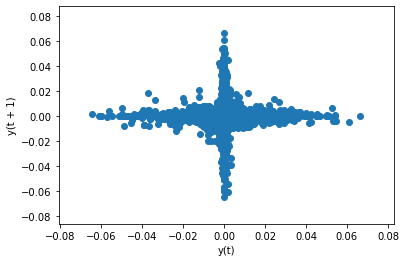

In [73]:
from pandas.plotting import lag_plot
lag_plot(cu_data.ta.percent_return().dropna())

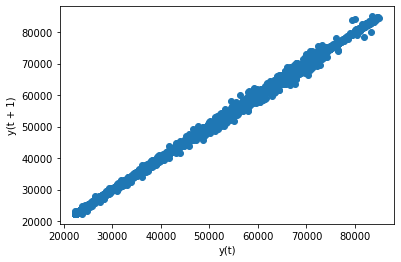

In [74]:
lag_plot(cu_data.close)

In [197]:
cu_data.head()

,date,open,close,high,low,volume,money,open_interest
0,2005-01-04 09:01:00,29110,29080,29170,29080,3158,459908300,121604
1,2005-01-04 09:02:00,29080,29100,29100,29030,1970,286417600,121806
2,2005-01-04 09:03:00,29110,29060,29110,29060,1418,206240600,122000
3,2005-01-04 09:04:00,29060,29070,29080,29050,942,136908100,122024
4,2005-01-04 09:05:00,29080,29070,29090,29060,1134,164892800,122198


In [204]:
cu_data['open'].index= cu_data.date

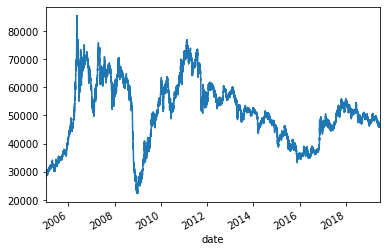

In [206]:
cu_data['open'].plot()


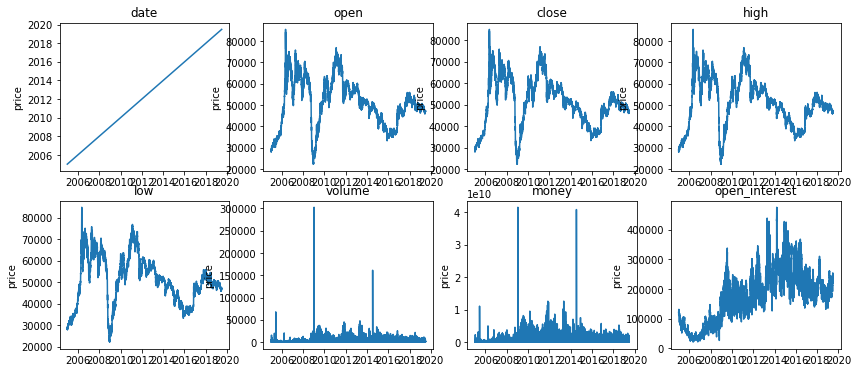

In [212]:
## afternoon visualization
fig, axes = plt.subplots(2,4, figsize=(14,6), squeeze = False)
for i, columns in enumerate(cu_data.columns):
    x = cu_data.date
    y = cu_data[columns]
    ax = axes[i//4, i%4]
    ax.plot(x,y)
    ax.set_title(columns)
    ax.set_ylabel('price')

## feature analysis
1. feature lists pandas_ta
2. analyze each feature and see if it's important
3. (there are overlaps of index analysis) https://github.com/twopirllc/pandas-ta

## comparison with other futures
1. correlation analysis
2. crossover analysis
3. (I am still confusing about this part)

In [27]:
### 沪深300股指期货
path = '/Users/tjmask/Desktop/quantitative strategy/data/'
if_data = pd.read_csv(path+'IF9999.csv',
                      infer_datetime_format=True,
                      parse_dates=[1])
if_data.drop('Unnamed: 0', axis=1, inplace=True)
## 中证500股指期货
ic_data = pd.read_csv(path+'IC9999.csv',
                      infer_datetime_format=True,
                      parse_dates=[1])
ic_data.drop('Unnamed: 0', axis=1, inplace=True)
## 上证50股指期货
ih_data = pd.read_csv(path+'IH9999.csv',
                      infer_datetime_format=True,
                      parse_dates=[1])
ih_data.drop('Unnamed: 0', axis=1, inplace=True)
# ## 沪深300股指期权
# io_data = pd.read_csv(path+'IO9999.csv',
#                       infer_datetime_format=True,
#                       parse_dates=[1])
# io_data.drop('Unnamed: 0', axis=1, inplace=True)
## 2年国债期货
ts_data = pd.read_csv(path+'TS9999.csv',
                      infer_datetime_format=True,
                      parse_dates=[1])
ts_data.drop('Unnamed: 0', axis=1, inplace=True)
## 5年国债期货
tf_data = pd.read_csv(path+'TF9999.csv',
                      infer_datetime_format=True,
                      parse_dates=[1])
tf_data.drop('Unnamed: 0', axis=1, inplace=True)
## 10年国债期货
t_data = pd.read_csv(path+'T9999.csv',
                      infer_datetime_format=True,
                      parse_dates=[1])
t_data.drop('Unnamed: 0', axis=1, inplace=True)

print("Done!")

Done!


In [310]:
if_data.shape,ic_data.shape, ih_data.shape, ts_data.shape, tf_data.shape,t_data.shape, cu_data.shape

((578250, 8),
 (251280, 8),
 (251280, 8),
 (55890, 8),
 (381510, 8),
 (281610, 8),
 (1106130, 8))

In [32]:
## merge data 
df_merge = pd.merge(cu_data[['date', 'close']], if_data[['date', 'close']], how='inner', on = ['date'])
df_merge = pd.merge(df_merge, ic_data[['date', 'close']], how='inner', on = ['date'])
df_merge = pd.merge(df_merge, ih_data[['date', 'close']], how='inner', on = ['date'])
df_merge = pd.merge(df_merge, tf_data[['date', 'close']], how='inner', on = ['date'])
df_merge = pd.merge(df_merge, t_data[['date', 'close']], how='inner', on = ['date'])
df_merge.columns = ['date','cu_close', 'if_close', 'ic_close', 'ih_close', 'tf_close', 't_close']
df_megre = df_merge.set_index('date')
df_merge.head()

,date,cu_close,if_close,ic_close,ih_close,tf_close,t_close
0,2015-04-17 09:16:00,43730,4519.8,7708.4,3303.0,97.180,96.140
1,2015-04-17 09:17:00,43720,4526.8,7700.4,3326.6,97.215,96.065
2,2015-04-17 09:18:00,43730,4522.0,7699.4,3321.2,97.195,96.105
3,2015-04-17 09:19:00,43720,4523.2,7686.0,3326.6,97.145,96.065
4,2015-04-17 09:20:00,43740,4527.8,7695.0,3333.8,97.145,96.080


### orignal price correlation

In [363]:
## 5 minutes frequency
mean_5 = df_megre.resample('5min', how ='mean').dropna()
## getting the correltation matrix
mean5_mat = mean_5.corr()
mean5_mat

,cu_close,if_close,ic_close,ih_close,tf_close,t_close
cu_close,1.000000,0.384598,-0.276792,0.629114,-0.700927,-0.795574
if_close,0.384598,1.000000,0.678618,0.922016,-0.648466,-0.512875
ic_close,-0.276792,0.678618,1.000000,0.354234,-0.200298,-0.016675
ih_close,0.629114,0.922016,0.354234,1.000000,-0.714739,-0.634050
tf_close,-0.700927,-0.648466,-0.200298,-0.714739,1.000000,0.959347
t_close,-0.795574,-0.512875,-0.016675,-0.634050,0.959347,1.000000


In [361]:
## 10 minutes frequency
mean_10 = df_megre.resample('10min', how ='mean').dropna()
## getting the correltation matrix
mean10_mat = mean_10.corr()
mean10_mat

,cu_close,if_close,ic_close,ih_close,tf_close,t_close
cu_close,1.000000,0.381708,-0.277743,0.626850,-0.699029,-0.794654
if_close,0.381708,1.000000,0.680734,0.922117,-0.648005,-0.511164
ic_close,-0.277743,0.680734,1.000000,0.357140,-0.202112,-0.017001
ih_close,0.626850,0.922117,0.357140,1.000000,-0.714180,-0.632565
tf_close,-0.699029,-0.648005,-0.202112,-0.714180,1.000000,0.958919
t_close,-0.794654,-0.511164,-0.017001,-0.632565,0.958919,1.000000


In [360]:
## 60 minutes frequency
mean_60 = df_megre.resample('60min', how ='mean').dropna()
## getting the correltation matrix
mean60_mat = mean_60.corr()
mean60_mat

,cu_close,if_close,ic_close,ih_close,tf_close,t_close
cu_close,1.000000,0.396815,-0.272744,0.638444,-0.708398,-0.799357
if_close,0.396815,1.000000,0.669718,0.921745,-0.650419,-0.520083
ic_close,-0.272744,0.669718,1.000000,0.342377,-0.193064,-0.015438
ih_close,0.638444,0.921745,0.342377,1.000000,-0.716937,-0.640153
tf_close,-0.708398,-0.650419,-0.193064,-0.716937,1.000000,0.960972
t_close,-0.799357,-0.520083,-0.015438,-0.640153,0.960972,1.000000


In [367]:
## one day frequency
oneday = df_megre.resample(rule='1D', how ='mean').dropna()
## getting the correltation matrix
oneday_mat = oneday.corr()
oneday_mat

,cu_close,if_close,ic_close,ih_close,tf_close,t_close
cu_close,1.000000,0.396376,-0.273518,0.638476,-0.708769,-0.799676
if_close,0.396376,1.000000,0.669844,0.921725,-0.651596,-0.520533
ic_close,-0.273518,0.669844,1.000000,0.342386,-0.193736,-0.015554
ih_close,0.638476,0.921725,0.342386,1.000000,-0.718138,-0.640732
tf_close,-0.708769,-0.651596,-0.193736,-0.718138,1.000000,0.961003
t_close,-0.799676,-0.520533,-0.015554,-0.640732,0.961003,1.000000


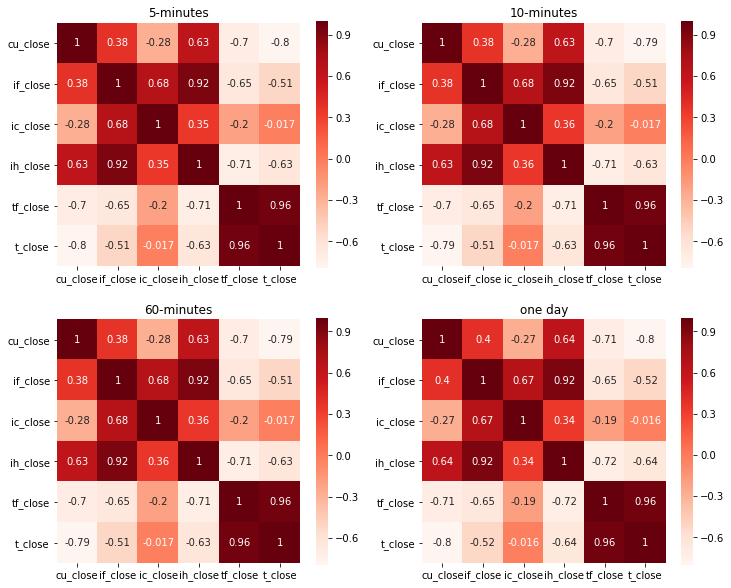

In [401]:
## heatmap for the four periods
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(12,10))
ax1,ax2,ax3,ax4 = axes.ravel()
sns.heatmap(mean5_mat, annot=True, vmax=1, square=True, cmap='Reds',ax=ax1)
ax1.set_title('5-minutes')
sns.heatmap(mean10_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax2)
ax2.set_title('10-minutes')
sns.heatmap(mean10_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax3)
ax3.set_title('60-minutes')
sns.heatmap(oneday_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax4)
ax4.set_title('one day')
plt.show()

From the result, we can see that Cu close price has strong relationship with IC, TF, T. And the 5,10,60 minutes as well as one day data changed a little, which means it's not periodical?

### high frequency price return correlation(30s, 1min, 5mins, 10mins, 30mins, 60mins)

In [ ]:
## get the first differential price ratio
cu_fdp = pd.DataFrame(cu_data.ta.percent_return())
cu_fdp.columns = ['cu_return']
cu_fdp =  cu_fdp.set_index(cu_data.date)

if_fdp = pd.DataFrame(if_data.ta.percent_return())
if_fdp.columns = ['if_return']
if_fdp =  if_fdp.set_index(if_data.date)

ic_fdp = pd.DataFrame(ic_data.ta.percent_return())
ic_fdp.columns = ['ic_return']
ic_fdp =  ic_fdp.set_index(ic_data.date)

ih_fdp = pd.DataFrame(ih_data.ta.percent_return())
ih_fdp.columns = ['ih_return']
ih_fdp =  ih_fdp.set_index(ih_data.date)

tf_fdp = pd.DataFrame(tf_data.ta.percent_return())
tf_fdp.columns = ['tf_return']
tf_fdp =  tf_fdp.set_index(tf_data.date)

t_fdp = pd.DataFrame(t_data.ta.percent_return())
t_fdp.columns = ['t_return']
t_fdp =  t_fdp.set_index(t_data.date)

In [75]:
## get merge data
return_merge = pd.merge(cu_fdp, if_fdp, how='inner', on = ['date'])
return_merge = pd.merge(return_merge, ic_fdp, how='inner', on = ['date'])
return_merge = pd.merge(return_merge, ih_fdp, how='inner', on = ['date'])
return_merge = pd.merge(return_merge, tf_fdp, how='inner', on = ['date'])
return_merge = pd.merge(return_merge, t_fdp, how='inner', on = ['date']).dropna()
return_merge.head()

,cu_return,if_return,ic_return,ih_return,tf_return,t_return
date,,,,,,
2015-04-17 09:17:00,-0.000229,0.001549,-0.001038,0.007145,0.000360,-0.000780
2015-04-17 09:18:00,0.000229,-0.001060,-0.000130,-0.001623,-0.000206,0.000416
2015-04-17 09:19:00,-0.000229,0.000265,-0.001740,0.001626,-0.000514,-0.000416
2015-04-17 09:20:00,0.000457,0.001017,0.001171,0.002164,0.000000,0.000156
2015-04-17 09:21:00,0.000000,0.000221,-0.000494,-0.000720,0.000000,0.000000


In [130]:
## 30 seconds frequency
return_30s = return_merge.resample(rule = '30S', how ='mean').dropna()
## getting the correltation matrix
return_30s_mat = return_30s.corr()

In [131]:
return_30s.head()

,cu_return,if_return,ic_return,ih_return,tf_return,t_return
date,,,,,,
2015-04-17 09:17:00,-0.000229,0.001549,-0.001038,0.007145,0.000360,-0.000780
2015-04-17 09:18:00,0.000229,-0.001060,-0.000130,-0.001623,-0.000206,0.000416
2015-04-17 09:19:00,-0.000229,0.000265,-0.001740,0.001626,-0.000514,-0.000416
2015-04-17 09:20:00,0.000457,0.001017,0.001171,0.002164,0.000000,0.000156
2015-04-17 09:21:00,0.000000,0.000221,-0.000494,-0.000720,0.000000,0.000000


In [110]:
## 1 minutes frequency
return_1min = return_merge.resample('1min', how ='mean').dropna()
## getting the correltation matrix
return_1min_mat = return_1min.corr()

In [109]:
## 5 minutes frequency
return_5min = return_merge.resample('5min', how ='mean').dropna()
## getting the correltation matrix
return_5min_mat = return_5min.corr()

In [108]:
## 10 minutes frequency
return_10min = return_merge.resample('10min', how ='mean').dropna()
## getting the correltation matrix
return_10min_mat = return_10min.corr()

In [106]:
## 30 minutes frequency
return_30min = return_merge.resample('30min', how ='mean').dropna()
## getting the correltation matrix
return_30min_mat = return_30min.corr()

In [107]:
## 60 minutes frequency
return_60min = return_merge.resample('60min', how ='mean').dropna()
## getting the correltation matrix
return_60min_mat = return_60min.corr()

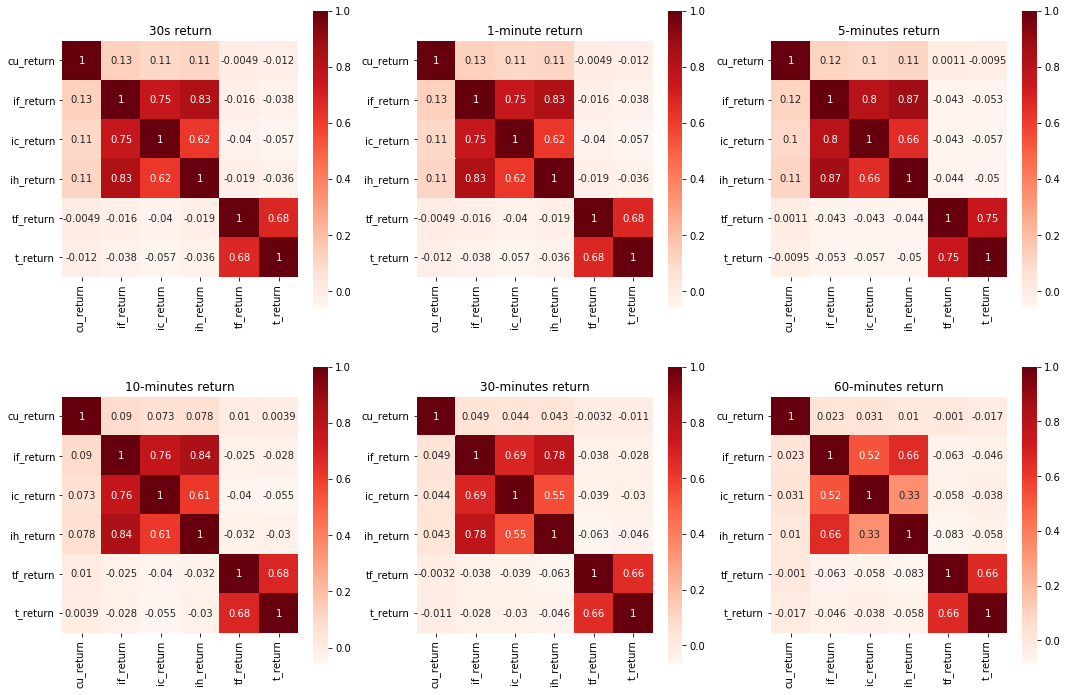

In [95]:
## heatmap for the six periods
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(18,12))
ax1,ax2,ax3,ax4,ax5,ax6 = axes.ravel()
sns.heatmap(return_30s_mat, annot=True, vmax=1, square=True, cmap='Reds',ax=ax1)
ax1.set_title('30s return')
sns.heatmap(return_1min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax2)
ax2.set_title('1-minute return')
sns.heatmap(return_5min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax3)
ax3.set_title('5-minutes return')
sns.heatmap(return_10min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax4)
ax4.set_title('10-minutes return')
sns.heatmap(return_30min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax5)
ax5.set_title('30-minutes return')
sns.heatmap(return_60min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax6)
ax6.set_title('60-minutes return')
plt.show()

### Hysteresis effect of price return

In [144]:
# ## 30s frequency
# price_30s = return_merge.resample(rule='30S', how ='mean').dropna()
# ## getting the correltation matrix
# price_30s_mat = price_30s.corr()

## 45 seconds frequency
return_45s = return_merge.resample(rule = '45S', how ='mean').dropna()
## getting the correltation matrix
return_45s_mat = return_45s.corr()

## one period shift
shift1_45s  = return_45s.ix[:,1:].shift(1)
shift1_45s = pd.merge(return_45s['cu_return'], shift1_45s, how ='inner', on ='date').dropna()
shift1_45s_mat = shift1_45s.corr()

In [137]:
# ## 1min frequency
# price_1m = df_megre.resample(rule='1min', how ='mean').dropna()
# ## getting the correltation matrix
# price_1m_mat = price_1m.corr()

## 1 minutes frequency
return_1min = return_merge.resample('1min', how ='mean').dropna()
## getting the correltation matrix
return_1min_mat = return_1min.corr()

## one period shift
shift1_1m  = return_1min.ix[:,1:].shift(1)
shift1_1m = pd.merge(return_1min['cu_return'], shift1_1m, how ='inner', on ='date').dropna()
shift1_1m_mat = shift1_1m.corr()

In [138]:
# ## 5min frequency
# price_5m = df_megre.resample(rule='5min', how ='mean').dropna()
# ## getting the correltation matrix
# price_5m_mat = price_5m.corr()

## 5 minutes frequency
return_5min = return_merge.resample('5min', how ='mean').dropna()
## getting the correltation matrix
return_5min_mat = return_5min.corr()

## one period shift
shift1_5m  = return_5min.ix[:,1:].shift(1)
shift1_5m = pd.merge(return_5min['cu_return'], shift1_5m, how ='inner', on ='date').dropna()
shift1_5m_mat = shift1_5m.corr()

In [140]:
# ## 10min frequency
# price_10m = df_megre.resample(rule='10min', how ='mean').dropna()
# ## getting the correltation matrix
# price_10m_mat = price_10m.corr()

## 10 minutes frequency
return_10min = return_merge.resample('10min', how ='mean').dropna()
## getting the correltation matrix
return_10min_mat = return_10min.corr()

## one period shift
shift1_10m  = return_10min.ix[:,1:].shift(1)
shift1_10m = pd.merge(return_10min['cu_return'], shift1_10m, how ='inner', on ='date').dropna()
shift1_10m_mat = shift1_10m.corr()

In [165]:
# ## 30min frequency
# price_30m = df_megre.resample(rule='30min', how ='mean').dropna()
# ## getting the correltation matrix
# price_30m_mat = price_30m.corr()

## 30 minutes frequency
return_30min = return_merge.resample('30min', how ='mean').dropna()
## getting the correltation matrix
return_30min_mat = return_30min.corr()

## one period shift
shift1_30m  = return_30min.ix[:,1:].shift(1)
shift1_30m = pd.merge(return_30min['cu_return'], shift1_30m, how ='inner', on ='date').dropna()
shift1_30m_mat = shift1_30m.corr()

In [164]:
shift1_30m.head()

,cu_return,if_return,ic_return,ih_return,tf_return,t_return
date,,,,,,
2015-04-17 09:30:00,-0.000076,0.000489,-0.000373,0.000763,0.000024,0.000052
2015-04-17 10:00:00,0.000057,0.000216,0.000792,-0.000342,-0.000027,-0.000026
2015-04-17 10:30:00,0.000071,0.000303,-0.000498,0.000073,-0.000013,0.000007
2015-04-17 11:00:00,-0.000023,-0.000041,0.000274,-0.000036,-0.000009,-0.000011
2015-04-17 11:30:00,0.000000,-0.000030,0.000079,-0.000123,-0.000007,-0.000007


In [142]:
# ## 60min frequency
# price_60m = df_megre.resample(rule='60min', how ='mean').dropna()
# ## getting the correltation matrix
# price_60m_mat = price_60m.corr()

## 60 minutes frequency
return_60min = return_merge.resample('60min', how ='mean').dropna()
## getting the correltation matrix
return_60min_mat = return_60min.corr()

## one period shift
shift1_60m  = return_60min.ix[:,1:].shift(1)
shift1_60m = pd.merge(return_60min['cu_return'], shift1_60m, how ='inner', on ='date').dropna()
shift1_60m_mat = shift1_60m.corr()

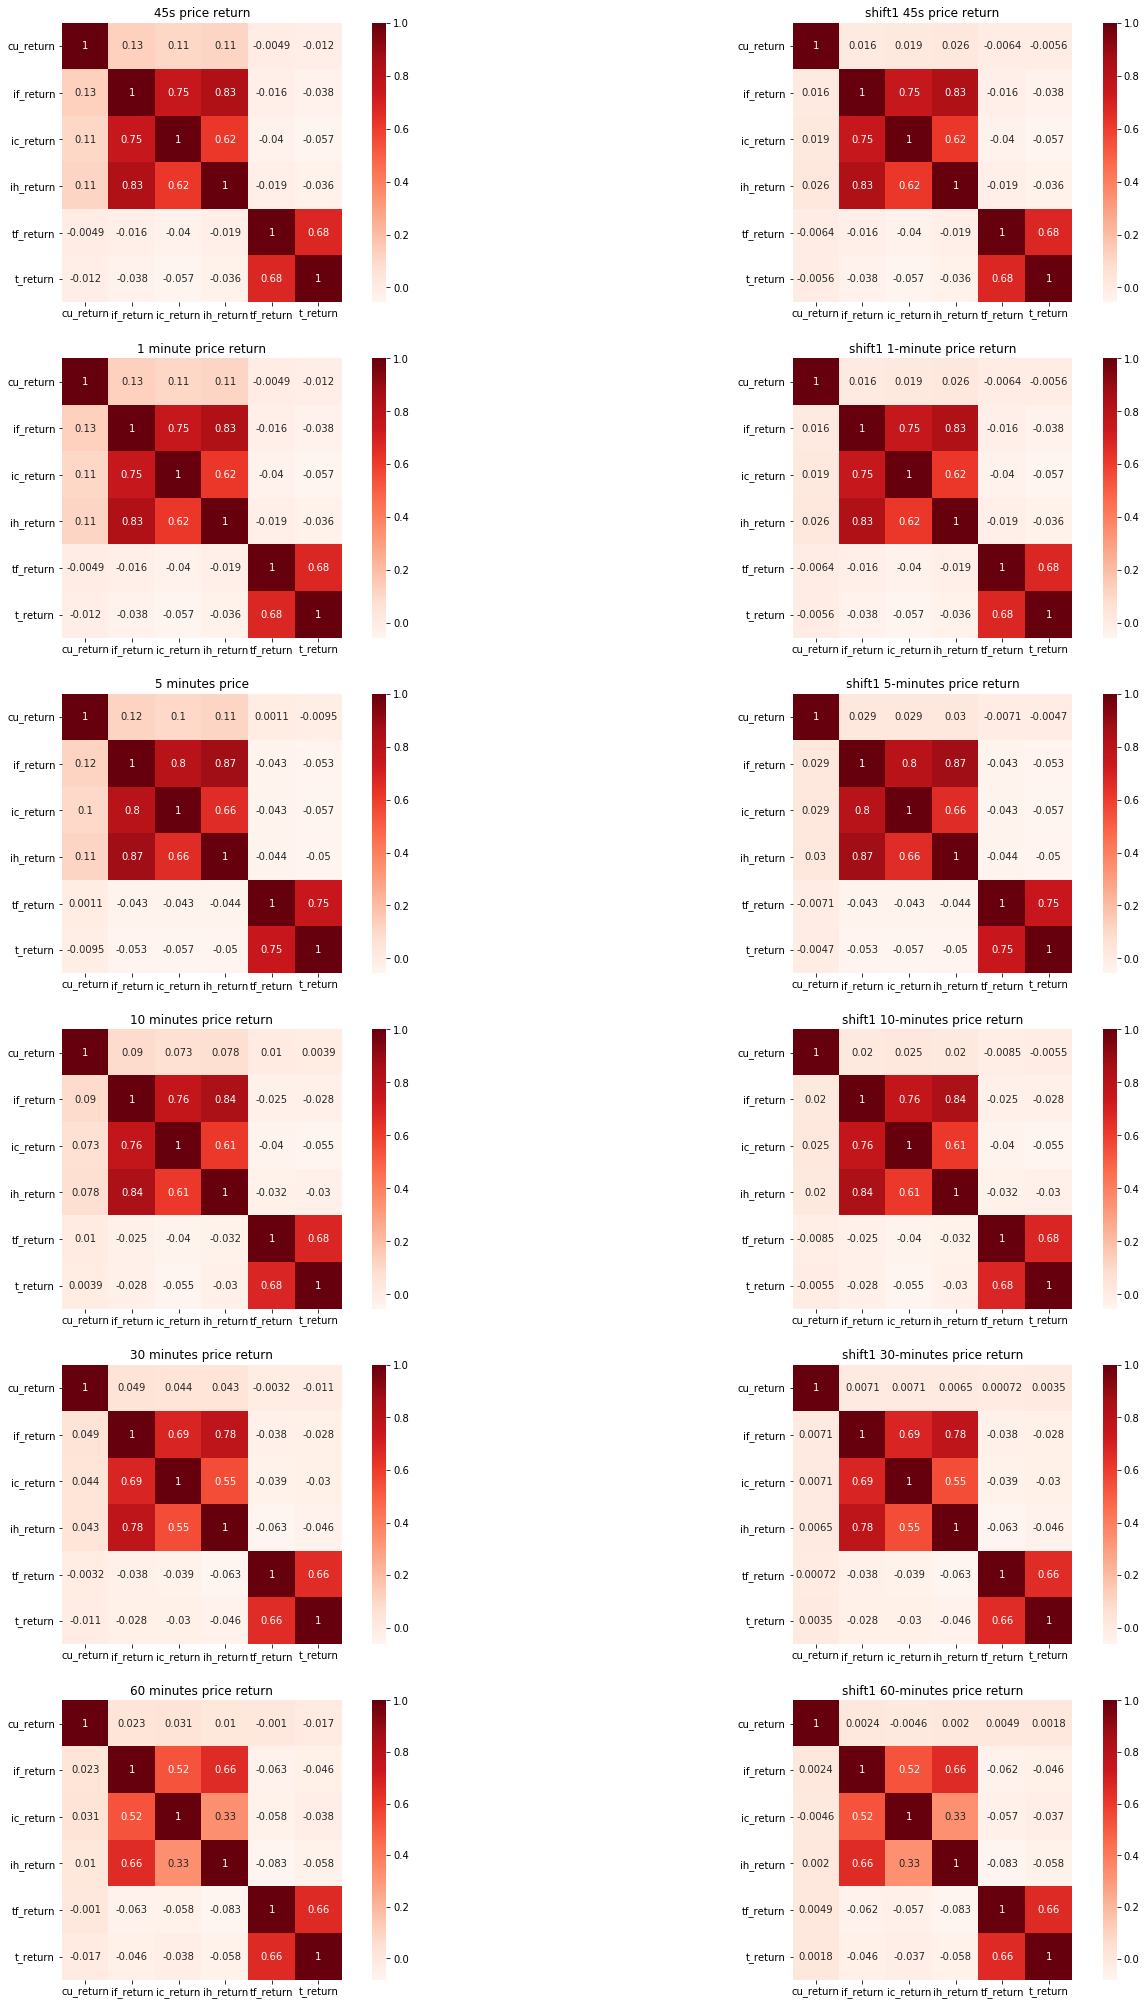

In [168]:
## heatmap for the six periods
fig,axes=plt.subplots(nrows=6,ncols=2,figsize=(24,36))
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12 = axes.ravel()

sns.heatmap(return_45s_mat, annot=True, vmax=1, square=True, cmap='Reds',ax=ax1)
ax1.set_title('45s price return')
sns.heatmap(shift1_45s_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax2)
ax2.set_title('shift1 45s price return')

sns.heatmap(return_1min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax3)
ax3.set_title('1 minute price return')
sns.heatmap(shift1_1m_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax4)
ax4.set_title('shift1 1-minute price return')

sns.heatmap(return_5min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax5)
ax5.set_title('5 minutes price')
sns.heatmap(shift1_5m_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax6)
ax6.set_title('shift1 5-minutes price return')

sns.heatmap(return_10min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax7)
ax7.set_title('10 minutes price return')
sns.heatmap(shift1_10m_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax8)
ax8.set_title('shift1 10-minutes price return')

sns.heatmap(return_30min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax9)
ax9.set_title('30 minutes price return')
sns.heatmap(shift1_30m_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax10)
ax10.set_title('shift1 30-minutes price return')

sns.heatmap(return_60min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax11)
ax11.set_title('60 minutes price return')
sns.heatmap(shift1_60m_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax12)
ax12.set_title('shift1 60-minutes price return')

plt.show()

In [184]:
return_5min.head()

,cu_return,if_return,ic_return,ih_return,tf_return,t_return
date,,,,,,
2015-04-17 09:15:00,-7.620789e-05,0.000251,-0.000969,0.002383,-0.000120,-2.599797e-04
2015-04-17 09:20:00,4.578747e-05,0.000363,-0.000234,0.000434,0.000103,1.144890e-04
2015-04-17 09:25:00,3.136367e-08,0.000759,-0.000154,0.000121,0.000031,1.768098e-04
2015-04-17 09:30:00,-2.741596e-04,0.000704,0.000621,-0.000717,-0.000031,1.567217e-08
2015-04-17 09:35:00,1.375408e-04,0.000589,0.001485,-0.000130,-0.000041,-8.316927e-05


In [183]:
if_shift1_5m.head()

,if_return,cu_return,ic_return,ih_return,tf_return,t_return
date,,,,,,
2015-04-17 09:20:00,0.000363,-7.620789e-05,-0.000969,0.002383,-0.000120,-2.599797e-04
2015-04-17 09:25:00,0.000759,4.578747e-05,-0.000234,0.000434,0.000103,1.144890e-04
2015-04-17 09:30:00,0.000704,3.136367e-08,-0.000154,0.000121,0.000031,1.768098e-04
2015-04-17 09:35:00,0.000589,-2.741596e-04,0.000621,-0.000717,-0.000031,1.567217e-08
2015-04-17 09:40:00,-0.000366,1.375408e-04,0.001485,-0.000130,-0.000041,-8.316927e-05


In [185]:
## 5 minutes frequency
return_5min = return_merge.resample('5min', how ='mean').dropna()
## getting the correltation matrix
return_5min_mat = return_5min.corr()

## one period shift
if_shift1_5m  = return_5min[['cu_return', 'ic_return','ih_return','tf_return','t_return']].shift(1)
if_shift1_5m = pd.merge(return_5min[['if_return']], if_shift1_5m , how ='inner', on ='date').dropna()
if_shift1_5m_mat = if_shift1_5m.corr()

In [186]:
if_shift1_5m.head()

,if_return,cu_return,ic_return,ih_return,tf_return,t_return
date,,,,,,
2015-04-17 09:20:00,0.000363,-7.620789e-05,-0.000969,0.002383,-0.000120,-2.599797e-04
2015-04-17 09:25:00,0.000759,4.578747e-05,-0.000234,0.000434,0.000103,1.144890e-04
2015-04-17 09:30:00,0.000704,3.136367e-08,-0.000154,0.000121,0.000031,1.768098e-04
2015-04-17 09:35:00,0.000589,-2.741596e-04,0.000621,-0.000717,-0.000031,1.567217e-08
2015-04-17 09:40:00,-0.000366,1.375408e-04,0.001485,-0.000130,-0.000041,-8.316927e-05


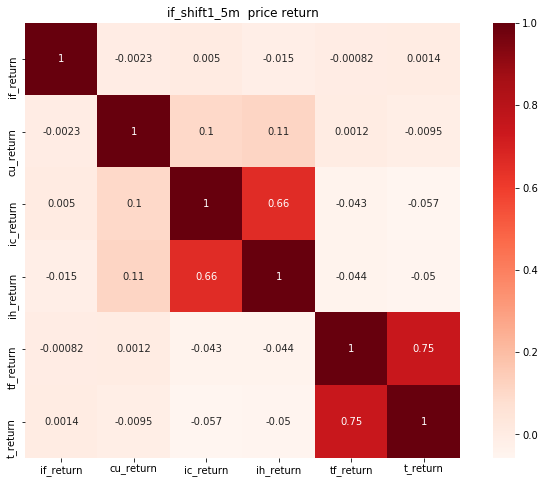

In [187]:
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(12,8))
sns.heatmap(if_shift1_5m_mat, annot=True, vmax=1, square=True, cmap='Reds')
axes.set_title('if_shift1_5m  price return')
plt.show()

In [157]:
return_45s.head()

,cu_return,if_return,ic_return,ih_return,tf_return,t_return
date,,,,,,
2015-04-17 09:16:30,-0.000229,0.001549,-0.001038,0.007145,0.000360,-0.000780
2015-04-17 09:18:00,0.000229,-0.001060,-0.000130,-0.001623,-0.000206,0.000416
2015-04-17 09:18:45,-0.000229,0.000265,-0.001740,0.001626,-0.000514,-0.000416
2015-04-17 09:19:30,0.000457,0.001017,0.001171,0.002164,0.000000,0.000156
2015-04-17 09:21:00,0.000000,0.000221,-0.000494,-0.000720,0.000000,0.000000


In [158]:
return_1min.head()

,cu_return,if_return,ic_return,ih_return,tf_return,t_return
date,,,,,,
2015-04-17 09:17:00,-0.000229,0.001549,-0.001038,0.007145,0.000360,-0.000780
2015-04-17 09:18:00,0.000229,-0.001060,-0.000130,-0.001623,-0.000206,0.000416
2015-04-17 09:19:00,-0.000229,0.000265,-0.001740,0.001626,-0.000514,-0.000416
2015-04-17 09:20:00,0.000457,0.001017,0.001171,0.002164,0.000000,0.000156
2015-04-17 09:21:00,0.000000,0.000221,-0.000494,-0.000720,0.000000,0.000000


In [34]:
## one week frequency
oneweek = df_megre.resample(rule='7D', how ='mean').dropna()
## getting the correltation matrix
oneweek_mat = oneweek.corr()
oneweek_mat

,cu_close,if_close,ic_close,ih_close,tf_close,t_close
cu_close,1.000000,0.410142,-0.275039,0.651930,-0.717334,-0.804775
if_close,0.410142,1.000000,0.656782,0.920109,-0.659245,-0.529694
ic_close,-0.275039,0.656782,1.000000,0.321176,-0.191195,-0.014297
ih_close,0.651930,0.920109,0.321176,1.000000,-0.722211,-0.646783
tf_close,-0.717334,-0.659245,-0.191195,-0.722211,1.000000,0.963393
t_close,-0.804775,-0.529694,-0.014297,-0.646783,0.963393,1.000000


In [35]:
## a week shift 
week_shift  = oneweek.ix[:,1:].shift(1)
week_later = pd.merge(oneweek['cu_close'], week_shift, how ='inner', on ='date').dropna()
week_later_mat = week_later.corr()
week_later_mat

,cu_close,if_close,ic_close,ih_close,tf_close,t_close
cu_close,1.000000,0.392772,-0.283756,0.635749,-0.699235,-0.789582
if_close,0.392772,1.000000,0.661205,0.921174,-0.660811,-0.530861
ic_close,-0.283756,0.661205,1.000000,0.329376,-0.189780,-0.012783
ih_close,0.635749,0.921174,0.329376,1.000000,-0.727633,-0.651285
tf_close,-0.699235,-0.660811,-0.189780,-0.727633,1.000000,0.963387
t_close,-0.789582,-0.530861,-0.012783,-0.651285,0.963387,1.000000


In [36]:
## two week shift 
week2_shift  = oneweek.ix[:,1:].shift(2)
week2_later = pd.merge(oneweek['cu_close'], week_shift, how ='inner', on ='date').dropna()
week2_later_mat = week2_later.corr()
week2_later_mat

,cu_close,if_close,ic_close,ih_close,tf_close,t_close
cu_close,1.000000,0.392772,-0.283756,0.635749,-0.699235,-0.789582
if_close,0.392772,1.000000,0.661205,0.921174,-0.660811,-0.530861
ic_close,-0.283756,0.661205,1.000000,0.329376,-0.189780,-0.012783
ih_close,0.635749,0.921174,0.329376,1.000000,-0.727633,-0.651285
tf_close,-0.699235,-0.660811,-0.189780,-0.727633,1.000000,0.963387
t_close,-0.789582,-0.530861,-0.012783,-0.651285,0.963387,1.000000


In [37]:
## one month shift 
week4_shift  = oneweek.ix[:,1:].shift(4)
week4_later = pd.merge(oneweek['cu_close'], week_shift, how ='inner', on ='date').dropna()
week4_later_mat = week4_later.corr()
week4_later_mat

,cu_close,if_close,ic_close,ih_close,tf_close,t_close
cu_close,1.000000,0.392772,-0.283756,0.635749,-0.699235,-0.789582
if_close,0.392772,1.000000,0.661205,0.921174,-0.660811,-0.530861
ic_close,-0.283756,0.661205,1.000000,0.329376,-0.189780,-0.012783
ih_close,0.635749,0.921174,0.329376,1.000000,-0.727633,-0.651285
tf_close,-0.699235,-0.660811,-0.189780,-0.727633,1.000000,0.963387
t_close,-0.789582,-0.530861,-0.012783,-0.651285,0.963387,1.000000


Text(0.5, 1, 'one month shift')

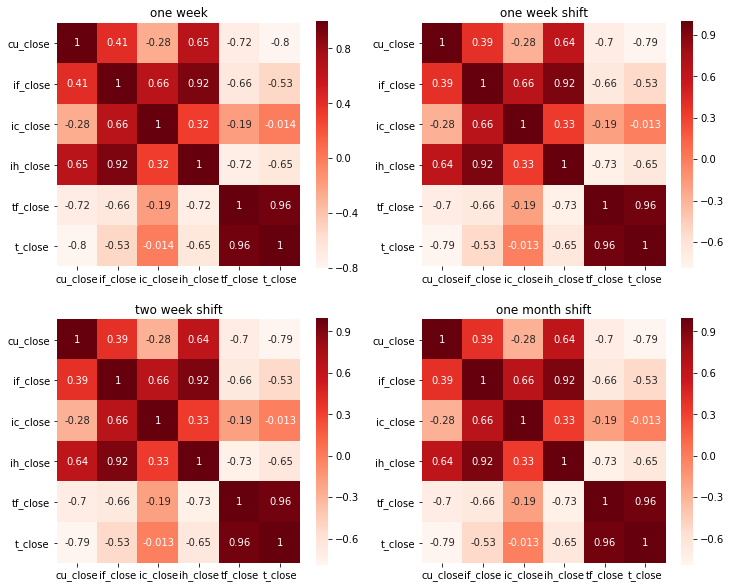

In [38]:
## heat map for one week and week shifts
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(12,10))
ax1,ax2,ax3,ax4 = axes.ravel()
sns.heatmap(oneweek_mat, annot=True, vmax=1, square=True, cmap='Reds',ax=ax1)
ax1.set_title('one week')
sns.heatmap(week_later_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax2)
ax2.set_title('one week shift')
sns.heatmap(week2_later_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax3)
ax3.set_title('two week shift')
sns.heatmap(week4_later_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax4)
ax4.set_title('one month shift')

It seems that there no hysteresis effect of price, however, this is because the price is highly correlated.And there might be stocastic trends. Thus we should dig deeper about the first differential price.

### Hysteresis effect of the first differential price 

In [49]:
## get the first differential price ratio
cu_fdp = pd.DataFrame(cu_data.ta.percent_return())
cu_fdp.columns = ['cu_return']
cu_fdp =  cu_fdp.set_index(cu_data.date)

if_fdp = pd.DataFrame(if_data.ta.percent_return())
if_fdp.columns = ['if_return']
if_fdp =  if_fdp.set_index(if_data.date)

ic_fdp = pd.DataFrame(ic_data.ta.percent_return())
ic_fdp.columns = ['ic_return']
ic_fdp =  ic_fdp.set_index(ic_data.date)

ih_fdp = pd.DataFrame(ih_data.ta.percent_return())
ih_fdp.columns = ['ih_return']
ih_fdp =  ih_fdp.set_index(ih_data.date)

tf_fdp = pd.DataFrame(tf_data.ta.percent_return())
tf_fdp.columns = ['tf_return']
tf_fdp =  tf_fdp.set_index(tf_data.date)

t_fdp = pd.DataFrame(t_data.ta.percent_return())
t_fdp.columns = ['t_return']
t_fdp =  t_fdp.set_index(t_data.date)

In [53]:
## get merge data
return_merge = pd.merge(cu_fdp, if_fdp, how='inner', on = ['date'])
return_merge = pd.merge(return_merge, ic_fdp, how='inner', on = ['date'])
return_merge = pd.merge(return_merge, ih_fdp, how='inner', on = ['date'])
return_merge = pd.merge(return_merge, tf_fdp, how='inner', on = ['date'])
return_merge = pd.merge(return_merge, t_fdp, how='inner', on = ['date']).dropna()
return_merge.head()

,cu_return,if_return,ic_return,ih_return,tf_return,t_return
date,,,,,,
2015-04-17 09:17:00,-0.000229,0.001549,-0.001038,0.007145,0.000360,-0.000780
2015-04-17 09:18:00,0.000229,-0.001060,-0.000130,-0.001623,-0.000206,0.000416
2015-04-17 09:19:00,-0.000229,0.000265,-0.001740,0.001626,-0.000514,-0.000416
2015-04-17 09:20:00,0.000457,0.001017,0.001171,0.002164,0.000000,0.000156
2015-04-17 09:21:00,0.000000,0.000221,-0.000494,-0.000720,0.000000,0.000000


### high frequency price return(30s, 1min, 5mins, 10mins, 30mins, 60mins)

##### weekly price return frequency

In [57]:
## one week price return frequency
weekly_return = return_merge.resample(rule='7D', how ='mean').dropna()
## getting the correltation matrix
weekly_return_mat = weekly_return.corr()
weekly_return_mat

,cu_return,if_return,ic_return,ih_return,tf_return,t_return
cu_return,1.000000,0.179907,0.195248,0.147256,-0.156879,-0.150190
if_return,0.179907,1.000000,0.881153,0.936289,-0.124591,-0.140349
ic_return,0.195248,0.881153,1.000000,0.720770,-0.147317,-0.165082
ih_return,0.147256,0.936289,0.720770,1.000000,-0.092248,-0.108463
tf_return,-0.156879,-0.124591,-0.147317,-0.092248,1.000000,0.888376
t_return,-0.150190,-0.140349,-0.165082,-0.108463,0.888376,1.000000


In [58]:
weekly_return.head()

,cu_return,if_return,ic_return,ih_return,tf_return,t_return
date,,,,,,
2015-04-17,-3.692577e-07,0.000057,0.000067,0.000020,0.000009,1.049529e-05
2015-04-24,1.120952e-06,-0.000004,0.000002,-0.000021,0.000001,1.229173e-06
2015-05-01,1.625513e-05,-0.000063,-0.000079,-0.000046,-0.000014,-9.312442e-06
2015-05-08,1.124074e-05,0.000050,0.000103,0.000017,0.000003,4.917282e-07
2015-05-15,3.551920e-06,0.000053,0.000069,0.000036,0.000008,-1.404454e-06


In [61]:
## a week shift 
w1_shift  = weekly_return.ix[:,1:].shift(1)
w1_later = pd.merge(weekly_return['cu_return'], w1_shift, how ='inner', on ='date').dropna()
w1_later_mat = w1_later.corr()
w1_later_mat

,cu_return,if_return,ic_return,ih_return,tf_return,t_return
cu_return,1.000000,0.058938,0.010231,0.071786,-0.014077,-0.000549
if_return,0.058938,1.000000,0.881725,0.936329,-0.124851,-0.140775
ic_return,0.010231,0.881725,1.000000,0.720963,-0.146010,-0.163451
ih_return,0.071786,0.936329,0.720963,1.000000,-0.092045,-0.108267
tf_return,-0.014077,-0.124851,-0.146010,-0.092045,1.000000,0.888150
t_return,-0.000549,-0.140775,-0.163451,-0.108267,0.888150,1.000000


In [62]:
## two week shift 
w2_shift  = weekly_return.ix[:,1:].shift(2)
w2_later = pd.merge(weekly_return['cu_return'], w2_shift, how ='inner', on ='date').dropna()
w2_later_mat = w2_later.corr()
w2_later_mat

,cu_return,if_return,ic_return,ih_return,tf_return,t_return
cu_return,1.000000,-0.097099,-0.048294,-0.123646,0.113395,0.114360
if_return,-0.097099,1.000000,0.881729,0.936464,-0.124828,-0.140781
ic_return,-0.048294,0.881729,1.000000,0.721134,-0.145945,-0.163345
ih_return,-0.123646,0.936464,0.721134,1.000000,-0.092256,-0.108911
tf_return,0.113395,-0.124828,-0.145945,-0.092256,1.000000,0.888372
t_return,0.114360,-0.140781,-0.163345,-0.108911,0.888372,1.000000


In [63]:
## one month shift  
w4_shift  = weekly_return.ix[:,1:].shift(4)
w4_later = pd.merge(weekly_return['cu_return'], w4_shift, how ='inner', on ='date').dropna()
w4_later_mat = w4_later.corr()
w4_later_mat

,cu_return,if_return,ic_return,ih_return,tf_return,t_return
cu_return,1.000000,-0.036456,0.009781,-0.037073,-0.055294,-0.032532
if_return,-0.036456,1.000000,0.881208,0.935731,-0.127152,-0.144256
ic_return,0.009781,0.881208,1.000000,0.719578,-0.147941,-0.166081
ih_return,-0.037073,0.935731,0.719578,1.000000,-0.094447,-0.112449
tf_return,-0.055294,-0.127152,-0.147941,-0.094447,1.000000,0.888388
t_return,-0.032532,-0.144256,-0.166081,-0.112449,0.888388,1.000000


Text(0.5, 1, 'one month return shift')

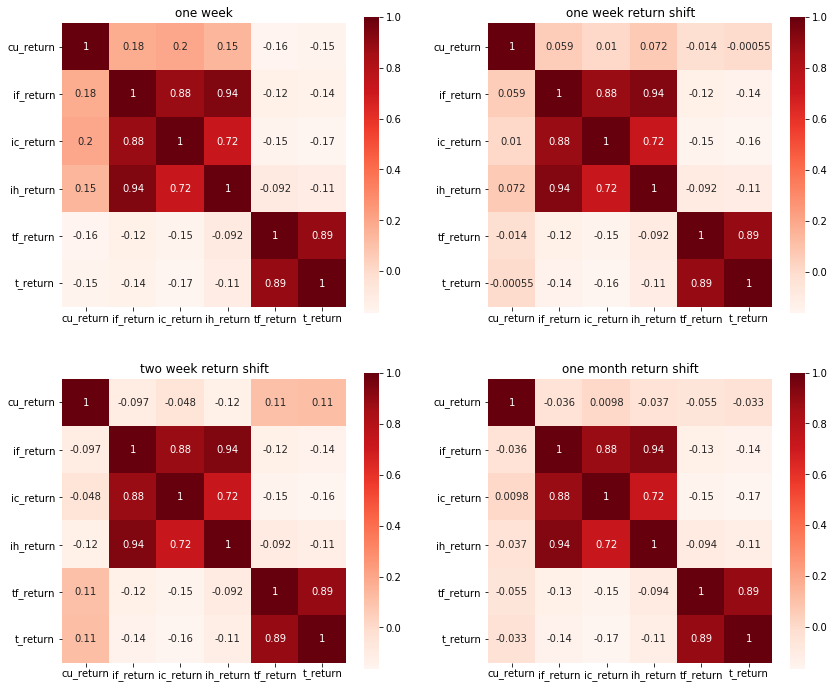

In [69]:
## heat map for one week and week shifts
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(14,12))
ax1,ax2,ax3,ax4 = axes.ravel()
sns.heatmap(weekly_return_mat, annot=True, vmax=1, square=True, cmap='Reds',ax=ax1)
ax1.set_title('one week')
sns.heatmap(w1_later_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax2)
ax2.set_title('one week return shift')
sns.heatmap(w2_later_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax3)
ax3.set_title('two week return shift')
sns.heatmap(w4_later_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax4)
ax4.set_title('one month return shift')

It seems that there no strong hysteresis effect of price return. One thing to pay attention is that the two weeks shift seems has opposite effect compare to non-shift data.

In [39]:
oneweek.head()

,cu_close,if_close,ic_close,ih_close,tf_close,t_close
date,,,,,,
2015-04-17,43477.942857,4640.099429,7957.301143,3262.025333,97.880300,97.071605
2015-04-24,43757.761905,4755.863810,8280.619429,3288.032190,98.271619,97.577290
2015-05-01,45773.726190,4656.045238,8173.248571,3206.440714,97.815405,97.452702
2015-05-08,45873.104762,4631.847429,8448.767810,3138.185143,97.548705,97.290133
2015-05-15,45547.352381,4696.973143,9015.974476,3098.399810,98.037614,96.861976


In [40]:
df_merge.head()

,date,cu_close,if_close,ic_close,ih_close,tf_close,t_close
0,2015-04-17 09:16:00,43730,4519.8,7708.4,3303.0,97.180,96.140
1,2015-04-17 09:17:00,43720,4526.8,7700.4,3326.6,97.215,96.065
2,2015-04-17 09:18:00,43730,4522.0,7699.4,3321.2,97.195,96.105
3,2015-04-17 09:19:00,43720,4523.2,7686.0,3326.6,97.145,96.065
4,2015-04-17 09:20:00,43740,4527.8,7695.0,3333.8,97.145,96.080


In [9]:
# cu_data.ta.percent_return()

In [428]:
oneweek.columns =['close','close','close','close','close','close']

In [443]:
oneweek.dtypes

close    float64
close    float64
close    float64
close    float64
close    float64
close    float64
dtype: object

In [453]:
oneweek.reset_index()['close'].ta.percent_return()

AttributeError: 'NoneType' object has no attribute 'pct_change'

In [452]:
oneweek.reset_index().head()

,date,close,close,close,close,close,close
0,2015-04-17,43477.942857,4640.099429,7957.301143,3262.025333,97.880300,97.071605
1,2015-04-24,43757.761905,4755.863810,8280.619429,3288.032190,98.271619,97.577290
2,2015-05-01,45773.726190,4656.045238,8173.248571,3206.440714,97.815405,97.452702
3,2015-05-08,45873.104762,4631.847429,8448.767810,3138.185143,97.548705,97.290133
4,2015-05-15,45547.352381,4696.973143,9015.974476,3098.399810,98.037614,96.861976


In [20]:
x = pd.DataFrame(cu_data.ta.percent_return(), if_data.ta.percent_return())


TypeError: __init__() got an unexpected keyword argument 'axis'

In [22]:
x = pd.DataFrame(cu_data.ta.percent_return())

In [24]:
x.set_index(cu_data['date'])

,PCTRET_1
date,
2005-01-04 09:01:00,NaN
2005-01-04 09:02:00,0.000688
2005-01-04 09:03:00,-0.001375
2005-01-04 09:04:00,0.000344
2005-01-04 09:05:00,0.000000
2005-01-04 09:06:00,-0.001376
2005-01-04 09:07:00,-0.002411
2005-01-04 09:08:00,0.000000
2005-01-04 09:09:00,0.000345


In [23]:
cu_data.head()

,date,open,close,high,low,volume,money,open_interest
0,2005-01-04 09:01:00,29110,29080,29170,29080,3158,459908300,121604
1,2005-01-04 09:02:00,29080,29100,29100,29030,1970,286417600,121806
2,2005-01-04 09:03:00,29110,29060,29110,29060,1418,206240600,122000
3,2005-01-04 09:04:00,29060,29070,29080,29050,942,136908100,122024
4,2005-01-04 09:05:00,29080,29070,29090,29060,1134,164892800,122198


In [319]:
# ## merge IF and CU
# if_close = if_data[['date', 'close']]
# cu_close = cu_data[['date', 'close']]
# cu_if = cu_close.merge(if_close, how='inner', on = ['date'])
# cu_if = cu_if.rename(columns ={'close_x':'cu_close', 'close_y':'if_close'})
# cu_if.head()

In [269]:
## 5 minutes rolling mean
mean_5 = cu_if[['cu_close', 'if_close']].rolling(300).mean()[300:]
mean_5.head()

,cu_close,if_close
300,60484.533333,3278.676000
301,60483.766667,3278.061333
302,60483.066667,3277.450667
303,60482.366667,3276.835333
304,60481.700000,3276.218667


In [273]:
cm = sns.light_palette("orange", as_cmap=True)
mean5_corr =  mean_5[['cu_close', 'if_close']].corr()

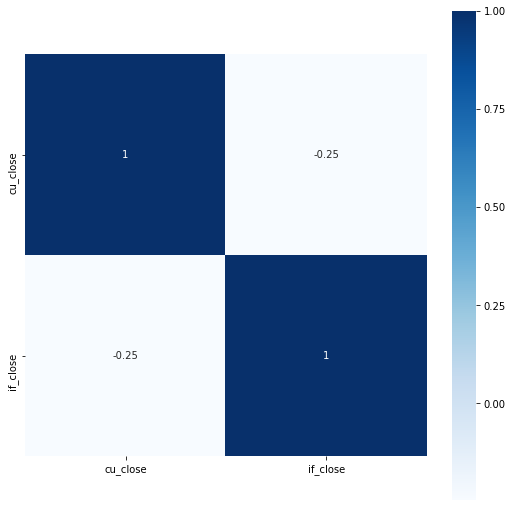

In [274]:
plt.subplots(figsize=(9, 9))
sns.heatmap(mean5_corr, annot=True, vmax=1, square=True, cmap="Blues")
plt.show()

In [276]:
## 10 minutes rolling mean
mean_10 = cu_if[['cu_close', 'if_close']].rolling(600).mean()[600:]
mean_10.head()

,cu_close,if_close
600,60556.316667,3248.871333
601,60556.216667,3248.651667
602,60556.166667,3248.431333
603,60556.083333,3248.212000
604,60556.100000,3247.999000


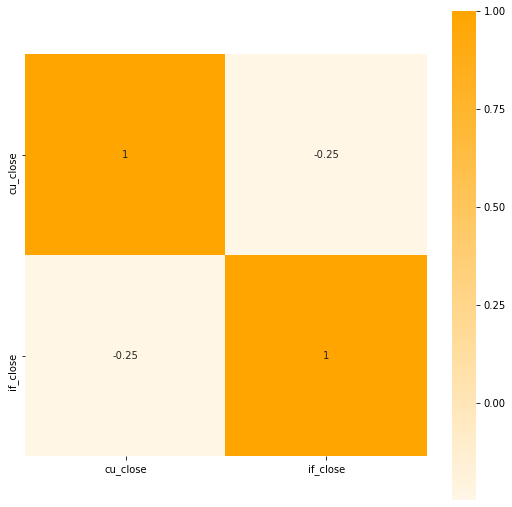

In [277]:
cm = sns.light_palette("orange", as_cmap=True)
mean10_corr =  mean_10[['cu_close', 'if_close']].corr()
plt.subplots(figsize=(9, 9))
sns.heatmap(mean10_corr, annot=True, vmax=1, square=True, cmap=cm)
plt.show()

In [278]:
cu_if.head()

,date,cu_close,if_close
0,2010-04-19 09:16:00,60820,3392.0
1,2010-04-19 09:17:00,60880,3394.8
2,2010-04-19 09:18:00,60850,3392.8
3,2010-04-19 09:19:00,60870,3393.6
4,2010-04-19 09:20:00,60860,3391.8


In [280]:
## 1 day 
cu_if_new =  cu_if.copy()
cu_if_new['date']  = cu_if_new.date.apply(lambda x: x.date())
cu_if_new.head()

,date,cu_close,if_close
0,2010-04-19,60820,3392.0
1,2010-04-19,60880,3394.8
2,2010-04-19,60850,3392.8
3,2010-04-19,60870,3393.6
4,2010-04-19,60860,3391.8


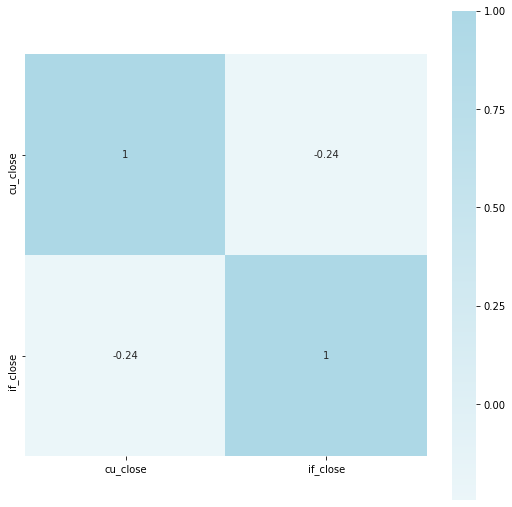

In [285]:
oneday  = cu_if_new.groupby('date').mean()
cm = sns.light_palette("lightblue", as_cmap=True)
oneday_corr =  oneday.corr()
plt.subplots(figsize=(9, 9))
sns.heatmap(oneday_corr, annot=True, vmax=1, square=True, cmap=cm)
plt.show()

In [286]:
oneday.head()

,cu_close,if_close
date,,
2010-04-19,60432.000000,3310.143810
2010-04-20,60636.619048,3204.607619
2010-04-21,60650.761905,3235.634286
2010-04-22,60759.571429,3243.411429
2010-04-23,60828.666667,3245.808571


In [289]:
oneday['if_close'].shift(1)

date
2010-04-19            NaN
2010-04-20    3310.143810
2010-04-21    3204.607619
2010-04-22    3235.634286
2010-04-23    3243.411429
2010-04-26    3245.808571
2010-04-27    3236.222857
2010-04-28    3146.571429
2010-04-29    3123.951429
2010-04-30    3142.205714
2010-05-04    3083.475238
2010-05-05    3076.995238
2010-05-06    3056.705714
2010-05-07    3034.851429
2010-05-10    2912.012381
2010-05-11    2904.189524
2010-05-12    2889.744762
2010-05-13    2821.425714
2010-05-14    2863.474286
2010-05-17    2871.881905
2010-05-18    2775.047619
2010-05-19    2740.068571
2010-05-20    2794.860000
2010-05-21    2791.114286
2010-05-24    2740.693333
2010-05-25    2890.237143
2010-05-26    2857.525714
2010-05-27    2844.864762
2010-05-28    2845.853333
2010-05-31    2895.978095
                 ...     
2019-05-17    3717.005128
2019-05-20    3640.980513
2019-05-21    3582.653333
2019-05-22    3635.278974
2019-05-23    3616.666667
2019-05-24    3566.873846
2019-05-27    3574.210256
2019-05

In [303]:
a  = pd.merge(oneday['cu_close'], oneday['if_close'].shift(14), on =oneday.index)

In [304]:
a.corr()

,cu_close,if_close
cu_close,1.000000,-0.251703
if_close,-0.251703,1.000000


In [ ]:
shop_open_mat = train.groupby(['shop_id','date_block_num'])\
                            .agg({'item_cnt_day': sum})\
                            .reset_index()\
                            .rename(columns={"item_cnt_day": "item_cnt"})\
                            .pivot(index='shop_id', columns='date_block_num', values='item_cnt')\
                            .fillna(0)
                            #.apply(lambda x: x*0+1)\
cm = sns.light_palette("orange", as_cmap=True)
shop_open_mat = shop_open_mat.style.background_gradient(cmap=cm)     
shop_open_mat

In [ ]:
cu_data.close.rolling(5, min_periods=1).agg({'max': np.max,
                      'min': np.min}).head()

In [ ]:
time_intvals = [(i+1)*5 for i in range(60)]
max_min_list = []
for intval in time_intvals:
    df = cu_data.close\
                .rolling(intval)\
                .agg({'max': np.max,
                      'min': np.min})\
                .dropna()\
                .astype('int32')
    max_min = np.mean(df['max']-df['min'])
    max_min_list.append(max_min)

## some hypothesis 
1. different time/trading period has significant impact on price and amount
2. holiday might have impact on price
3. firday or monday might have impact as well 
4. breaks(big events) should have impact 

## summary
1. which features are important
2. what conclusion are useful for futrue analysis

# Data exploratory

## Load data

In [2]:
## load data
cu_path = '/Users/tjmask/Desktop/quantitative strategy/data/cu9999.csv'
cu_data = pd.read_csv(cu_path,
                      infer_datetime_format=True,
                      parse_dates=[1],
                      dtype={'open': 'int32',
                          'close': 'int32',
                          'high': 'int32',
                          'low': 'int32',
                          'money': 'int64',
                          'volume': 'int32',
                          'open_interest': 'int32'})
cu_data.drop('Unnamed: 0', axis=1, inplace=True)
print("Done!")

Done!


## EDA

### A simple grasp of the data

In [3]:
cu_data.head()

,date,open,close,high,low,volume,money,open_interest
0,2005-01-04 09:01:00,29110,29080,29170,29080,3158,459908300,121604
1,2005-01-04 09:02:00,29080,29100,29100,29030,1970,286417600,121806
2,2005-01-04 09:03:00,29110,29060,29110,29060,1418,206240600,122000
3,2005-01-04 09:04:00,29060,29070,29080,29050,942,136908100,122024
4,2005-01-04 09:05:00,29080,29070,29090,29060,1134,164892800,122198


In [4]:
print("There are %d row in this dataset" % len(cu_data))

There are 1106130 row in this dataset


In [5]:
cu_data.nunique()

date             1106130
open                5791
close               5780
high                5785
low                 5773
volume              6546
money             915230
open_interest     174817
dtype: int64

From the result we can see that there are lots of same numbers on 'open','close','high','low','volume'

In [30]:
## cu_data.ix[:,1:]
## cu_data[['open','close']]

In [8]:
cu_data.describe()

,open,close,high,low,volume,money,open_interest
count,1.106130e+06,1.106130e+06,1.106130e+06,1.106130e+06,1.106130e+06,1.106130e+06,1.106130e+06
mean,4.956153e+04,4.956156e+04,4.957742e+04,4.954559e+04,8.085406e+02,1.970416e+08,1.980860e+05
std,1.025534e+04,1.025529e+04,1.025862e+04,1.025198e+04,1.291170e+03,3.122175e+08,8.265543e+04
min,2.227000e+04,2.227000e+04,2.231000e+04,2.221000e+04,0.000000e+00,0.000000e+00,2.108000e+04
25%,4.308000e+04,4.308000e+04,4.310000e+04,4.306000e+04,1.640000e+02,3.984230e+07,1.584120e+05
50%,4.931000e+04,4.931000e+04,4.933000e+04,4.930000e+04,4.080000e+02,9.880375e+07,2.043860e+05
75%,5.525000e+04,5.525000e+04,5.527000e+04,5.523000e+04,9.340000e+02,2.271672e+08,2.504420e+05
max,8.550000e+04,8.500000e+04,8.550000e+04,8.482000e+04,3.026620e+05,4.157062e+10,4.751440e+05


In [7]:
# cu_data.ix[:,1:]

### Visualization 

Text(0.5, 1.0, 'Hist of close')

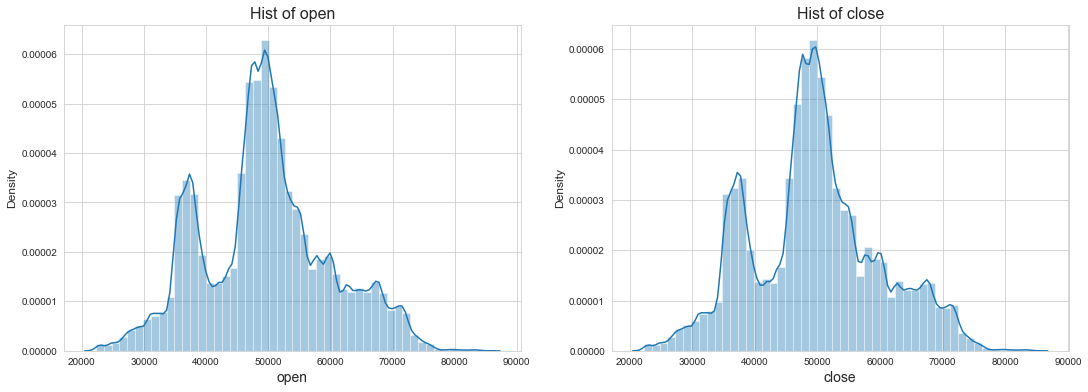

In [37]:
## plotting distributions of each column 
# open
plt.figure(figsize=(18,6))
plt.subplot(121)
sns.set_style("whitegrid")
sns.distplot(cu_data["open"])
plt.ylabel('Density', fontsize=12)
plt.xlabel('open', fontsize=14)
plt.title('Hist of open', fontsize=16)

# close
plt.subplot(122)
sns.set_style("whitegrid")
sns.distplot(cu_data["close"])
plt.ylabel('Density', fontsize=12)
plt.xlabel('close', fontsize=14)
plt.title('Hist of close', fontsize=16)

From the visualization, we can see that, distributions of 'open' and 'close' are quite similar, this might be because the open price is the close price of the last day, while there's still some dissimilarity

Text(0.5, 1.0, 'Hist of low')

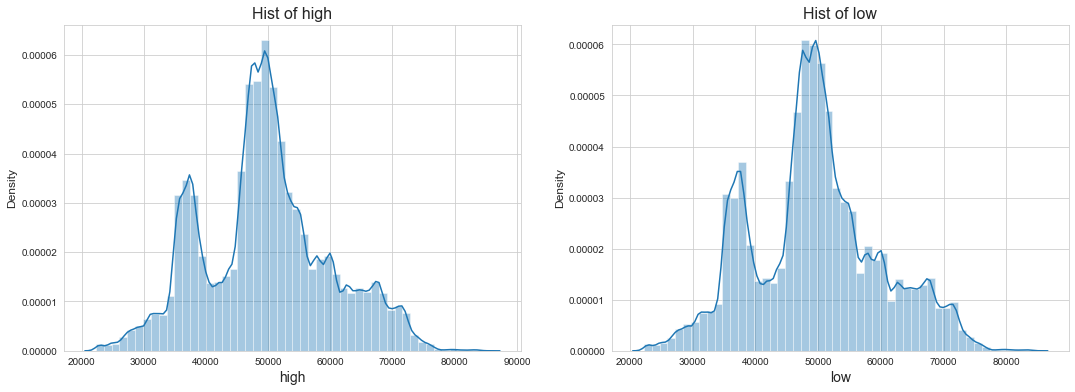

In [41]:
# high
plt.figure(figsize=(18,6))
plt.subplot(121)
sns.set_style("whitegrid")
sns.distplot(cu_data["high"])
plt.ylabel('Density', fontsize=12)
plt.xlabel('high', fontsize=14)
plt.title('Hist of high', fontsize=16)

# low
plt.subplot(122)
sns.set_style("whitegrid")
sns.distplot(cu_data["low"])
plt.ylabel('Density', fontsize=12)
plt.xlabel('low', fontsize=14)
plt.title('Hist of low', fontsize=16)

From the visualization, we can see that, distributions of 'high' and 'low' are quite similar, why is that? Probably it is because a high price usually followed by a low price?

Text(0.5, 1.0, 'Hist of money')

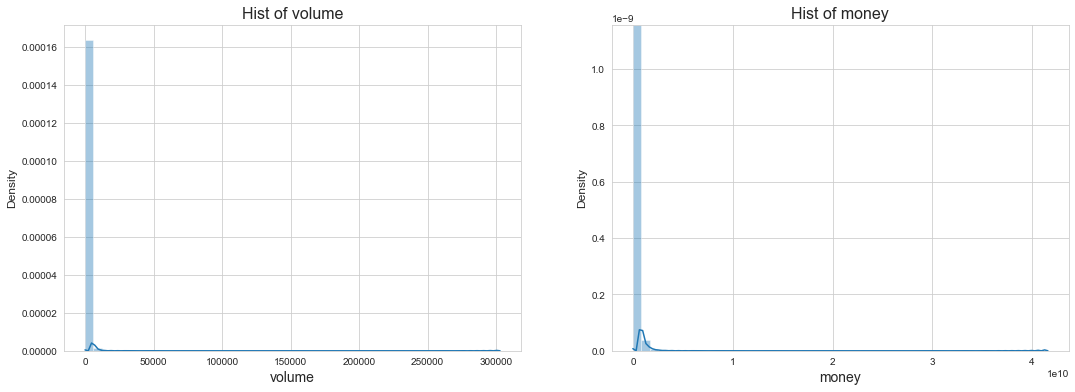

In [42]:
# volume
plt.figure(figsize=(18,6))
plt.subplot(121)
sns.set_style("whitegrid")
sns.distplot(cu_data["volume"])
plt.ylabel('Density', fontsize=12)
plt.xlabel('volume', fontsize=14)
plt.title('Hist of volume', fontsize=16)

# money
plt.subplot(122)
sns.set_style("whitegrid")
sns.distplot(cu_data["money"])
plt.ylabel('Density', fontsize=12)
plt.xlabel('money', fontsize=14)
plt.title('Hist of money', fontsize=16)

In [48]:
print("The max money is %d, min money is %d" % (cu_data["money"].max(), cu_data["money"].min()))
print("The max volume is %d, min volume is %d" % (cu_data["volume"].max(), cu_data["volume"].min()))

The max money is 41570625000, min money is 0
The max volume is 302662, min volume is 0


The graph is kind of werid, there should be some outliers which should be removed

Text(0.5, 1.0, 'Hist of open_interest')

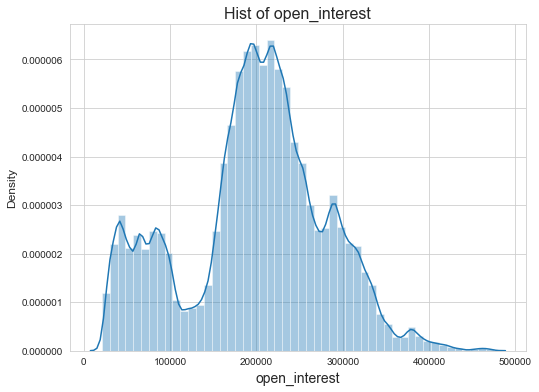

In [49]:
## open interest
plt.figure(figsize=(18,6))
plt.subplot(121)
sns.set_style("whitegrid")
sns.distplot(cu_data["open_interest"])
plt.ylabel('Density', fontsize=12)
plt.xlabel('open_interest', fontsize=14)
plt.title('Hist of open_interest', fontsize=16)

The open interest graph is more compressed

In [54]:
cu_data.head()

,date,open,close,high,low,volume,money,open_interest
0,2005-01-04 09:01:00,29110,29080,29170,29080,3158,459908300,121604
1,2005-01-04 09:02:00,29080,29100,29100,29030,1970,286417600,121806
2,2005-01-04 09:03:00,29110,29060,29110,29060,1418,206240600,122000
3,2005-01-04 09:04:00,29060,29070,29080,29050,942,136908100,122024
4,2005-01-04 09:05:00,29080,29070,29090,29060,1134,164892800,122198


datetime.date(2005, 1, 4)

### random check

In [63]:
unique_dates = cu_data.date.map(lambda x: x.date()).unique()

In [65]:
len(unique_dates)

3768

In [66]:
sample_dates = np.random.choice(unique_dates, 9)
sample_dates

array([datetime.date(2010, 3, 26), datetime.date(2015, 8, 22),
       datetime.date(2018, 5, 21), datetime.date(2016, 7, 23),
       datetime.date(2011, 8, 29), datetime.date(2012, 3, 27),
       datetime.date(2015, 6, 27), datetime.date(2011, 12, 8),
       datetime.date(2018, 11, 30)], dtype=object)

In [72]:
for i, date in enumerate(sample_dates):
    print(i, date)

0 2010-03-26
1 2015-08-22
2 2018-05-21
3 2016-07-23
4 2011-08-29
5 2012-03-27
6 2015-06-27
7 2011-12-08
8 2018-11-30


In [83]:
cu_data.date[1]

Timestamp('2005-01-04 09:02:00')

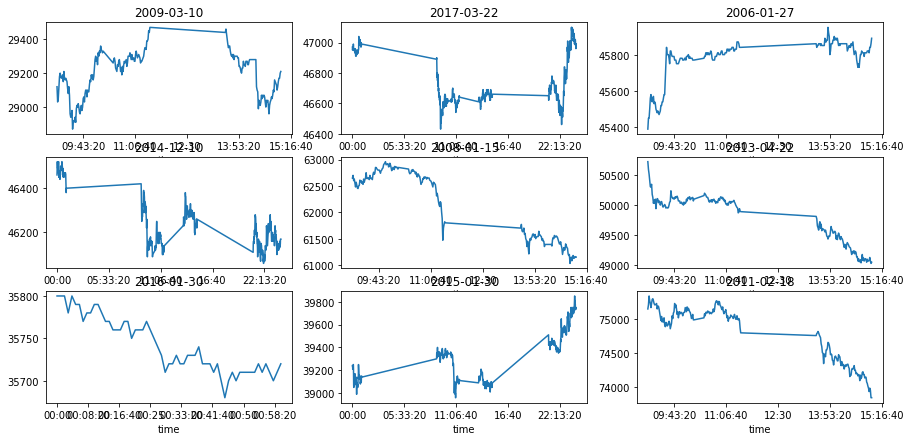

In [32]:
fig, axes = plt.subplots(3, 3, figsize=(15,7), squeeze=False)
for i, date in enumerate(sample_dates):
    plot_df = cu_data[cu_data.date.map(lambda x: x.date()==date)]
    x = plot_df.date.map(lambda x: x.time())
    y = plot_df.close
    ax = axes[i//3, i%3]
    ax.plot(x, y)
    ax.set_title(str(date))

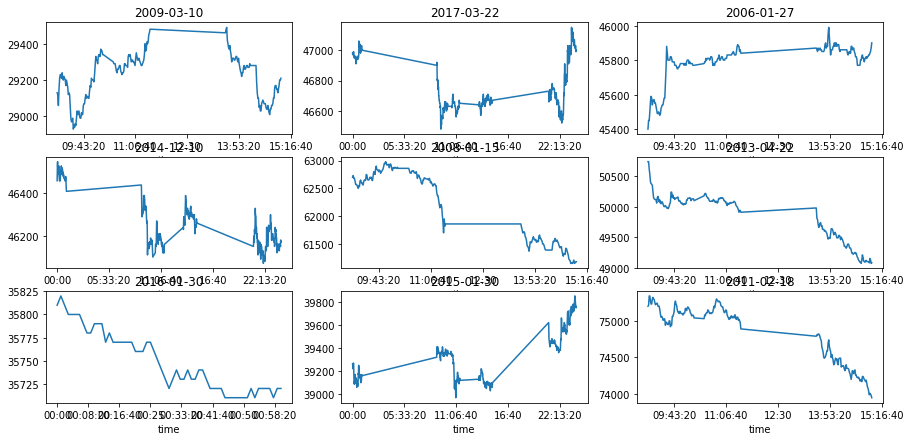

In [34]:
fig, axes = plt.subplots(3, 3, figsize=(15,7), squeeze=False)
for i, date in enumerate(sample_dates):
    plot_df = cu_data[cu_data.date.map(lambda x: x.date()==date)]
    x = plot_df.date.map(lambda x: x.time())
    y = plot_df.high
    ax = axes[i//3, i%3]
    ax.plot(x, y)
    ax.set_title(str(date))

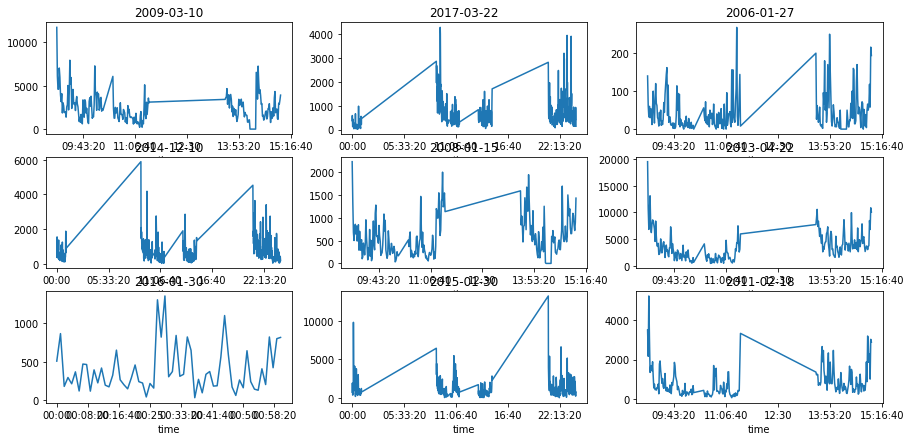

In [35]:
fig, axes = plt.subplots(3, 3, figsize=(15,7), squeeze=False)
for i, date in enumerate(sample_dates):
    plot_df = cu_data[cu_data.date.map(lambda x: x.date()==date)]
    x = plot_df.date.map(lambda x: x.time())
    y = plot_df.volume
    ax = axes[i//3, i%3]
    ax.plot(x, y)
    ax.set_title(str(date))

### price fluctuation

In [127]:
time_intvals = [(i+1)*5 for i in range(60)]
max_min_list = []
for intval in time_intvals:
    df = cu_data.close\
                .rolling(intval)\
                .agg({'max': np.max,
                      'min': np.min})\
                .dropna()\
                .astype('int32')
    max_min = np.mean(df['max']-df['min'])
    max_min_list.append(max_min)

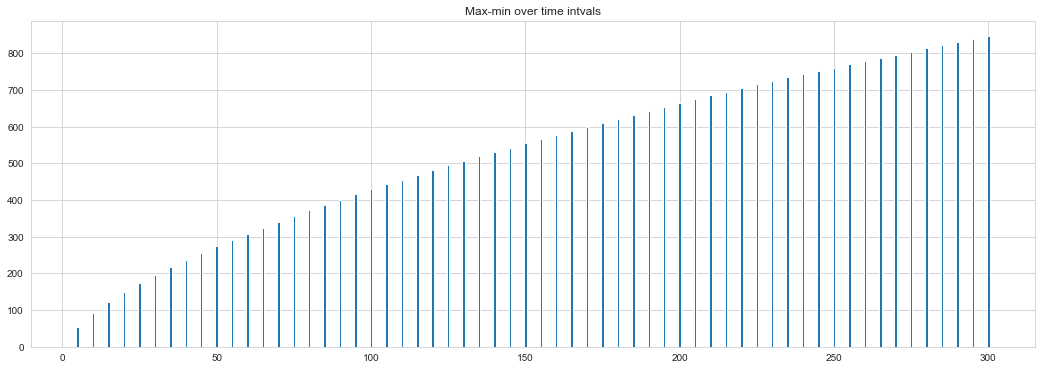

In [130]:
plt.figure(figsize=(18,6))
plt.bar(time_intvals, max_min_list)
plt.title('Max-min over time intvals')
plt.show()


In [131]:
spread = 20
unit = 5
cost = 15
print('Possible profits over time interval: ', (np.array(max_min_list)-spread)*unit - cost)

Possible profits over time interval:  [ 150.6708187   344.31417087  497.59167212  630.62833206  750.88681374
  862.28439808  966.95310353 1066.25913691 1161.15777616 1252.56408437
 1340.89801243 1426.29124622 1508.98062141 1589.32955325 1667.618692
 1743.9725971  1818.4878477  1891.2093087  1961.82159532 2030.8317624
 2098.51491737 2164.97311986 2230.25156056 2294.50478793 2357.75534672
 2420.0247875  2481.36865775 2541.66443036 2601.02154096 2659.51113536
 2717.16602349 2774.05265147 2830.33760532 2886.02806518 2941.13311018
 2995.70657742 3049.83761413 3103.44578508 3156.50409246 3209.04720548
 3261.10283147 3312.65052838 3363.66564911 3414.10333653 3463.85855579
 3511.00404557 3556.89821647 3602.21819782 3647.04830335 3691.44644406
 3735.47324474 3779.13408074 3822.4683732  3865.49542393 3908.2872544
 3950.83640111 3993.13033641 4035.17145322 4076.98104421 4118.54531569]


In [ ]:
cu_data.high-cu_data.open

In [109]:
max_min_list

[53.134163739031536,
 91.86283417456137,
 122.51833442423761,
 149.12566641141802,
 173.1773627482357,
 195.45687961587595,
 216.39062070561687,
 236.2518273812914,
 255.23155523169083,
 273.51281687326696,
 291.1796024866284,
 308.2582492443975]

In [89]:
time_intvals = [(i+1)*5 for i in range(12)]
time_intvals

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

In [113]:
cu_data.close.rolling(5, min_periods=1).agg({'max': np.max,
                      'min': np.min}).head()

,max,min
0,29080.0,29080.0
1,29100.0,29080.0
2,29100.0,29060.0
3,29100.0,29060.0
4,29100.0,29060.0


In [ ]:
index=pd.date_range('20190116','20190216')
np.random.seed(2)
data=np.random.randint(20,size=len(index))
ser_data=pd.Series(data,index=index)
plt.figure(figsize=(15, 5))
ser_data.plot(style='r--')
ser_data.rolling(3).mean().plot(style='b')

In [92]:
index=pd.date_range('20190116','20190216')
index

DatetimeIndex(['2019-01-16', '2019-01-17', '2019-01-18', '2019-01-19',
               '2019-01-20', '2019-01-21', '2019-01-22', '2019-01-23',
               '2019-01-24', '2019-01-25', '2019-01-26', '2019-01-27',
               '2019-01-28', '2019-01-29', '2019-01-30', '2019-01-31',
               '2019-02-01', '2019-02-02', '2019-02-03', '2019-02-04',
               '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08',
               '2019-02-09', '2019-02-10', '2019-02-11', '2019-02-12',
               '2019-02-13', '2019-02-14', '2019-02-15', '2019-02-16'],
              dtype='datetime64[ns]', freq='D')

In [93]:
data=np.random.randint(20,size=len(index))
data

array([ 2,  1,  8, 15,  7,  2,  1,  2,  8,  3,  9,  5,  6,  4,  0, 11, 15,
        3,  8,  5, 11,  9,  3, 16, 10,  6,  1, 13,  1,  0, 14, 18])

In [107]:
ser_data=pd.Series(data,index=index)

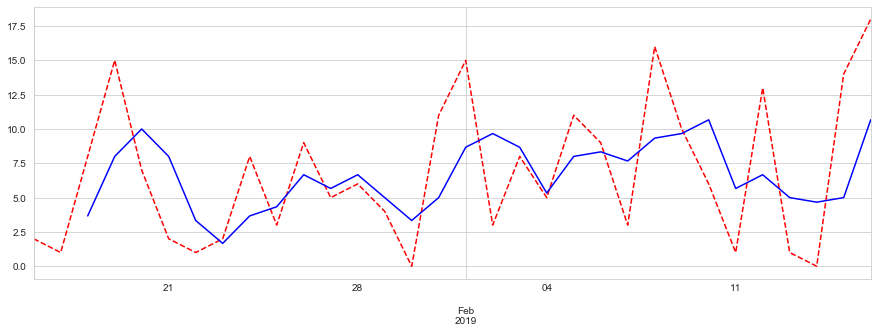

In [95]:
plt.figure(figsize=(15, 5))
ser_data.plot(style='r--')
ser_data.rolling(3).mean().plot(style='b')

In [97]:
df1=pd.DataFrame({'sex':list('FFMFMMF'),'smoker':list('YNYYNYY'),'age':[21,30,17,37,40,18,26],'weight':[120,100,132,140,94,89,123]})
df1

,sex,smoker,age,weight
0,F,Y,21,120
1,F,N,30,100
2,M,Y,17,132
3,F,Y,37,140
4,M,N,40,94
5,M,Y,18,89
6,F,Y,26,123


In [102]:
grouped = df1.groupby(['sex','smoker'])
grouped['age']

In [103]:
grouped['age'].agg('mean')

sex  smoker
F    N         30.0
     Y         28.0
M    N         40.0
     Y         17.5
Name: age, dtype: float64